In [1]:
import torch
import torch.nn as nn
import json
import pickle
import numpy as np
from random import shuffle, random
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from math import log2

In [2]:
# Extract data from the specified location
def Extract_Data ( loc ) :
    file = open(loc, 'r')
    data = file.read()
    data = data.split('\n')[:-1]
    data = [ x.split(',') for x in data ]
    data = [ (x[:-1], eval(x[-1])) for x in data ]
    data = [ ([eval(x) for x in X], _) for X, _ in data ]
    return data

# Given the probability distribution of a discrete attribute for its different values
# in the form of a vector, find the entropy of that attribute.
def Entropy ( dist ) :
    vals = np.array(list(dist.values()))
    vals = vals / vals.sum()
    s = sum(vals * np.log2(vals))
    if ( s == 0.0 ) : return 0
    return -1 * s

# Given the data matrix, study the various properties of the attributes.
def Study_Attributes ( data_matrix ) :
    std_dev_atts = np.std(data_matrix, axis = 0)
    
    # Study standard deviation in the values of the attributes
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.set(font_scale = 1.2)
    sns.heatmap(std_dev_atts.reshape((8, 8)))
    plt.title('STD. DEVIATION IN THE ATTRIBUTE VALUES\n', fontsize=13, fontweight='bold')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.plot()
    plt.savefig('PREPROCESSING_std_dev_attributes.png')
    
    # Study diversity in the values of the attributes
    distinct_att_vals = np.zeros(64, dtype = np.int32)
    attribute_entropies = [ ]
    for att in range(64) :
        dist = Counter(data_matrix[:, att])
        distinct_att_vals[att] = len(dist.keys())
        attribute_entropies.append(Entropy(dist))
    attribute_entropies = np.array(attribute_entropies)
    
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.set(font_scale = 1.2)
    sns.heatmap(distinct_att_vals.reshape((8, 8)))
    plt.title('DIVERSITY IN THE ATTRIBUTE VALUES\n', fontsize=13, fontweight='bold')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.plot()
    plt.savefig('PREPROCESSING_diversity_attributes.png')
    
    # Study entropy in the values of the attributes
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.set(font_scale = 1.2)
    sns.heatmap(attribute_entropies.reshape((8, 8)))
    plt.title('ENTROPY OF THE ATTRIBUTES\n', fontsize=13, fontweight='bold')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.plot()
    plt.savefig('PREPROCESSING_entropy_attributes.png')
    
    return std_dev_atts, distinct_att_vals, attribute_entropies

# Filter those attributes that have entropy below some threshold. Please refer
# to the report for more theoretical details.
def Filter_Attributes ( data , entropy_thresh = 0.1 ) :
    X = np.array([ X for X, _ in data ])
    _, _, attribute_entropies = Study_Attributes(X)
    data_filtered = [([X[t] for t in range(64) if attribute_entropies[t] >= entropy_thresh], y) for X, y in data ]
    return data_filtered

In [3]:
# Load data from the given locations. One location is for
# the training data and the other is for test data.
def Load_Data ( loc1 , loc2 ) :
    data = Extract_Data(loc1) + Extract_Data(loc2) # merge the sub-datasets
    data = Filter_Attributes(data) # filter attributes
    return data

# Split the entire dataset into train & test in the given ratio.
def Split ( data , train_split_ratio = 0.8 ) :
    shuffle(data)
    size = round(train_split_ratio * len(data))
    train_set = data[:size]
    test_set = data[size:]
    return train_set, test_set
    
    # Train & test both should have a balanced frequency of data samples
    # from each of the class otherwise unreliable results can be obtained.
    class_samples = [ [xy for xy in data if xy[1] == c] for c in range(10) ]
    [ shuffle(_) for _ in class_samples ]
    
    train_set = [ ]
    test_set = [ ]
    for c in range(10) :
        b = random() * 0.4 - 0.2 # small deviation
        s = round((train_split_ratio + b) * len(class_samples[c]))
        train_set.extend(class_samples[c][:s])
        test_set.extend(class_samples[c][s:])
    
    shuffle(train_set)
    shuffle(test_set)
    return train_set, test_set

In [4]:
# Package the train data into mini-batches of the given size and
# return the list of batches.
def Make_Batches ( train_data , batch_size = 32 ) :
    shuffle(train_data)
    batches = list()
    for start in range(0, len(train_data), batch_size) :
        end = start + batch_size
        batch, labels = list(zip(*train_data[start:end]))
        labels = torch.Tensor(labels).long()
        batch = torch.Tensor(batch).float()
        batches.append((batch, labels))
    return batches

In [5]:
# Multi-Layer Perceptron Classifier
class Handwritten_Digits_Classifier ( nn.Module ) :
    def __init__ ( self , name , input_size , hidden_layer_sizes , 
                  output_size , lr = 0.01 , momentum = 0.8 , early_stopping_tol = 4 ) :
        super(Handwritten_Digits_Classifier, self).__init__()
        self.__name = name
        self.__input_size = input_size
        self.__hidden_layer_sizes = hidden_layer_sizes
        self.__output_size = output_size
        
        self.__hidden_layers = [ ]
        hidden_input_size = input_size
        for size in hidden_layer_sizes :
            layer = nn.Linear(hidden_input_size, size, bias = True)
            self.__hidden_layers.append(layer)
            hidden_input_size = size
        
        self.__output_layer = nn.Linear(hidden_input_size, output_size, bias = True)
        self.__loss = nn.CrossEntropyLoss()
        self.__optimizer = torch.optim.SGD(self.parameters(), lr = lr, momentum = momentum)
        
        self.__training_history = {
            'train_loss_progress' : [ ],
            'train_acc_progress' : [ ],
            'valid_acc_progress' : [ ]
        }
        
        # Additional information
        self.__stopping_reason = 'Kernel interrupted'
        self.__learning_rate = lr
        self.__momentum = momentum
        self.__early_stopping_tol = early_stopping_tol
        self.__training_time = None
        self.__batch_size = None
    
    def forward ( self , batch_input ) :
        batch_output = batch_input
        for layer in self.__hidden_layers :
            batch_output = layer(batch_output)
        batch_output = self.__output_layer(batch_output)
        return batch_output
    
    def backward ( self , pred_label_dist , true_labels ) :
        loss = self.__loss(pred_label_dist, true_labels)
        self.__optimizer.zero_grad()
        loss.backward()
        self.__optimizer.step()
        return loss.item()
    
    def _accuracy ( self , data ) :
        self.eval()
        total_correct = 0
        tensor_samples = Make_Batches(data, 1)
        for _, (sample, label) in enumerate(tensor_samples) :
            label_dist = self(sample)
            pred = torch.argmax(label_dist, dim = 1)
            corr_count = (pred == label).sum()
            total_correct += corr_count
        self.train()
        return total_correct.item() / len(data)
    
    def _loss ( self , data ) :
        self.eval()
        total_loss = 0
        tensor_samples = Make_Batches(data, 1)
        for _, (sample, label) in enumerate(tensor_samples) :
            label_dist = self(sample)
            total_loss += self.__loss(label_dist, label).item()
        self.train()
        return total_loss / len(data)
    
    def _predict ( self , x ) :
        x = np.array(x, dtype = np.float32).reshape((1, -1))
        x = torch.from_numpy(x)
        label_dist = self(x)
        pred = torch.argmax(label_dist, dim = 1)
        return pred.item()
    
    def _confusion_matrix ( self , data ) :
        cf = np.zeros((10, 10), dtype = np.int32)
        for x, y in data :
            cf[y][self._predict(x)] += 1
        return cf
    
    def _plot_confusion_matrix ( self , data , loc , title = 'CONFUSION MATRIX (TRAIN DATA)' ) :
        cf = self._confusion_matrix(data)
        fig = plt.figure(figsize=(4, 3))
        ax = fig.add_subplot()
        sns.set(font_scale = 1.0)
        sns.heatmap(cf / np.sum(cf, axis = 1).reshape(10, 1))
        plt.title(self.__name + '\n' + title, fontsize=11, fontweight='bold')
        plt.xlabel('PREDICTED CLASS', fontsize=9)
        plt.ylabel('TRUE CLASS', fontsize=9)
        plt.tight_layout()
        plt.show()
        return
    
    def _plot_training_history ( self , loc ) :
        fontsize = 12
        plt.style.use('seaborn-whitegrid')
        
        epochs = len(self.__training_history['train_loss_progress'])
        X = list(range(1, 1 + epochs))
        
        plt.figure(figsize=(4.2, 3.2))
        plt.plot(X, self.__training_history['train_acc_progress'], linewidth = 2.2)
        plt.plot(X, self.__training_history['valid_acc_progress'], linewidth = 1.9)
        plt.xlabel('EPOCH', fontsize=fontsize)
        plt.ylabel('ACCURACY', fontsize=fontsize)
        plt.legend(['Train Acc.', 'Validation Acc.'], fontsize = 9)
        plt.title(self.__name + ' -- ACCURACY PROGRESS', fontsize=11, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(4.2, 3.2))
        plt.plot(X, self.__training_history['train_loss_progress'], linewidth = 2, color = '#d62728')
        plt.xlabel('EPOCH', fontsize=fontsize)
        plt.ylabel('LOSS', fontsize=fontsize)
        plt.title(self.__name + ' -- LOSS PROGRESS', fontsize=11, fontweight='bold')
        plt.tight_layout()
        plt.show()
        return
    
    # Prints a detailed report about training, accuracies, losses etc including the
    # plots and confusion matrices.
    def _model_analysis_report ( self , train_data , test_data ) :
        print('   +++ MODEL ANALYSIS REPORT +++')
        
        print('\n >> INTRODUCTION')
        print(' • NAME :', self.__name)
        print(' • INPUT SIZE :', self.__input_size)
        print(' • OUTPUT SIZE :', self.__output_size)
        
        print('\n >> HYPERPARAMETERS')
        print(' • HIDDEN LAYERS SIZES :', self.__hidden_layer_sizes)
        print(' • LEARNING RATE :', self.__learning_rate)
        print(' • BATCH SIZE :', self.__batch_size)
        print(' • MOMENTUM :', self.__momentum)
        print(' • EARLY STOPPING TOLERANCE :', self.__early_stopping_tol)
        
        print('\n >> TRAINING INFORMATION')
        print(' • EPOCHS :', len(self.__training_history['train_loss_progress']))
        print(' • TRAINING TIME : {:.3f} mins'.format(self.__training_time / 60))
        print(' • STOPPING REASON :', self.__stopping_reason)
        print(' • STOPPING TRAIN LOSS : {:.5f}'.format(self.__training_history['train_loss_progress'][-1]))
        print(' • STOPPING TRAIN ACCURACY : {:.3f} %'.
              format(100 * self.__training_history['train_acc_progress'][-1]))
        print(' • STOPPING VALIDATION ACCURACY : {:.3f} %'.
              format(100 * self.__training_history['valid_acc_progress'][-1]))
        
        print('\n >> TRAINING PROGRESS')
        self._plot_training_history(self.__name + str(self.__learning_rate)[2:] + 'prog.png')
        
        print('\n >> MODEL TESTING - ACCURACY & LOSS')
        train_acc = 100 * self._accuracy(train_data)
        test_acc = 100 * self._accuracy(test_data)
        print(' • TRAIN ACCURACY : {:.3f} %'.format(train_acc))
        print(' • TEST ACCURACY : {:.3f} %'.format(test_acc))
        print(' • TRAIN LOSS : {:.5f}'.format(self._loss(train_data)))
        print(' • TEST LOSS : {:.5f}'.format(self._loss(test_data)))
        
        print('\n >> MODEL TESTING - CONFUSION MATRICES')
        self._plot_confusion_matrix(train_data, self.__name + str(self.__learning_rate)[2:] + 'train_cf.png', 
                                    title = 'CONFUSION MATRIX (TRAIN DATA)')
        self._plot_confusion_matrix(test_data, self.__name + str(self.__learning_rate)[2:] + 'test_cf.png', 
                                    title = 'CONFUSION MATRIX (TEST DATA)')
        
        return train_acc, test_acc
    
    # Strict training is used when we have to train a model for a specific number of epochs, no matter if
    # the model starts to over-fit or the train loss starts increasing. So the model must be trained exactly
    # for a certain number of epochs, without early-stopping, therefore there is no need for validation set.
    # Though, the accuracy of the model on the test set is registered while training, after every epoch. This
    # type of training is used only while tuning the hyperparameter "Number of Training Epochs" in the 4th part.
    def _strict_train ( self , total_epochs , train_data , test_data , 
                        batch_size = 16 , verbose = False , verboseGap = 1 ) :
        self.train()
        train_acc_prog = []
        test_acc_prog = []
        for epoch in range(1, 1 + total_epochs) :
            total_loss = 0.0
            total_correct = 0
            batches = Make_Batches(train_data, batch_size)
            
            for _, (batch, labels) in enumerate(batches) :
                label_dists = self(batch)
                loss = self.backward(label_dists, labels)
                total_loss += loss
                pred = torch.argmax(label_dists, dim = 1)
                corr_count = (pred == labels).sum()
                total_correct += corr_count
            
            train_acc = self._accuracy(train_data)
            avg_loss = round(self._loss(train_data), 5)
            test_acc = round(self._accuracy(test_data), 5)
            train_acc_prog.append(train_acc)
            test_acc_prog.append(test_acc)
            
            if verbose and (epoch - 1) % verboseGap == 0 :
                print(' EPOCH : {:3d} | TRAIN LOSS : {:.5f} | TRAIN ACC. : {:.5f} | TEST ACC. : {:.5f} '.
                      format(epoch, avg_loss, train_acc, test_acc))
        
        self.eval()
        return train_acc_prog, test_acc_prog
    
    # Training on the train data. The training can terminate due to -
    # EARLY STOPPING (very common) - when validation accuracy starts decreasing or train loss starts increasing.
    # MAX EPOCHS REACHED (rare) - when the model is trained for the maximum allowed number of epochs.
    # TERMINAL ACCURACY REACHED (very rare) - when model's accuracy on train set exceeds a very high threshold.
    def _train ( self , train_data , validation_ratio = 0.2 , batch_size = 16 ,
                 total_epochs = 200 , terminal_train_acc = 99.0 , verbose = False ) :
        
        self.__batch_size = batch_size
        self.train()
        L = len(train_data)
        
        train_size = int(0.8 * L)
        train_set = train_data[:train_size]
        valid_set = train_data[train_size:]
        
        train_loss_change = [ 1 ] * self.__early_stopping_tol
        valid_acc_change = [ 1 ] * self.__early_stopping_tol
        last_train_loss = float('inf')
        last_valid_acc = 0.0
        start_time = time()

        for epoch in range(1, 1 + total_epochs) :
            total_loss = 0.0
            total_correct = 0
            batches = Make_Batches(train_set, batch_size)
            
            for _, (batch, labels) in enumerate(batches) :
                label_dists = self(batch)
                loss = self.backward(label_dists, labels)
                total_loss += loss
                pred = torch.argmax(label_dists, dim = 1)
                corr_count = (pred == labels).sum()
                total_correct += corr_count
            
            train_acc = self._accuracy(train_set)
            avg_loss = round(self._loss(train_set), 5)
            valid_acc = round(self._accuracy(valid_set), 5)
            
            self.__training_history['train_loss_progress'].append(avg_loss)
            self.__training_history['train_acc_progress'].append(train_acc)
            self.__training_history['valid_acc_progress'].append(valid_acc)
            
            if verbose :
                print(' EPOCH : {:3d} | TRAIN LOSS : {:.5f} | TRAIN ACC. : {:.5f} | VALIDATION ACC. : {:.5f} '.
                      format(epoch, avg_loss, train_acc, valid_acc))
            
            if train_acc >= terminal_train_acc :
                self.__training_time = time() - start_time
                if verbose : print('\n [ STOPPING : Terminal training accuracy reached ]')
                self.__stopping_reason = 'Terminal training accuracy was reached'
                self.eval()
                return
            
            if valid_acc >= last_valid_acc :
                valid_acc_change = valid_acc_change[1:] + [ 1 ]
                last_valid_acc = valid_acc
            else :
                valid_acc_change = valid_acc_change[1:] + [ 0 ]
                if sum(valid_acc_change) == 0 :
                    self.__training_time = time() - start_time
                    if verbose : print('\n [ EARLY STOPPING : Validation Accuracy not increasing ]')
                    self.__stopping_reason = '[Early Stopping] Validation accuracy was not increasing'
                    self.eval()
                    return
                last_valid_acc = valid_acc
            
            if avg_loss <= last_train_loss :
                train_loss_change = train_loss_change[1:] + [ 1 ]
                last_train_loss = avg_loss
            else :
                train_loss_change = train_loss_change[1:] + [ 0 ]
                if sum(train_loss_change) == 0 :
                    self.__training_time = time() - start_time
                    if verbose : print('\n [ EARLY STOPPING : Training Loss not decreasing ]')
                    self.__stopping_reason = '[Early Stopping] Training loss was not decreasing'
                    self.eval()
                    return
                last_train_loss = avg_loss
        
        self.__training_time = time() - start_time
        if verbose : print('\n [ STOPPING : Max no. of training epochs reached ]')
        self.__stopping_reason = 'Maximum number of epochs was reached'
        self.eval()
        return

In [6]:
def Data_Matrix ( data ) :
    X = [ x for x, _ in data ]
    X = np.array(X)
    X = X.transpose()
    return X

def Covariance_Matrix ( data ) :
    N = len(data)
    X = Data_Matrix(data)
    mean = X.mean(axis = 1)
    mean = np.tile(mean, (N,1)).transpose()
    X_minus_mean = X - mean
    cov = np.matmul(X_minus_mean, X_minus_mean.transpose())
    return cov / N

# Return the first and second principal component directions for the
# given data matrix.
def PCA_Component_Weights ( data , verbose = False ) :
    cov = Covariance_Matrix(data)
    d = cov.shape[0]
    if verbose :
        eig = list(np.linalg.eig(cov)[0])
        eig.sort(reverse = True)
        for i in range(len(eig)) :
            print(' EIGEN VAL {:2d} : {:.5f}'.format(i+1, eig[i]))
    eig = np.linalg.eig(cov)
    W = [ (i, eig[1][:,i]) for i in range(d) ] # all the components
    W.sort(key = lambda k: eig[0][k[0]], reverse = True) 
    # sort the components by their corresponding eigen-value
    W = [ t for _, t in W ]
    return np.array(W[:2]) # return the 1st & 2nd principal component directions

# Given the matrix W, this function returns the reduced dimensionality 
# data points for the given data (reduced to 2 dimensions).
def Two_Dim_Points ( data , W ) :
    x_higher = Data_Matrix(data)
    x_2d = np.matmul(W, x_higher).transpose()
    l = len(data)
    transformed = [ [list(x_2d[i]), data[i][1]] for i in range(l) ]
    return transformed

In [7]:
# Plots data samples (reduced to 2 dimensions) on a Cartesian plane, belonging to the given classes
def Plot_2D_Transformed_Data ( data_full , classes = list(range(10)) , s = 3 , alpha = 1 ) :
    data = [ [x, y] for x, y in data_full if y in classes ]
    points = [ p for p, _ in data ]
    x, y = list(zip(*points))
    colors = ['#1aa3ff', '#ff8c00', 'tab:green', '#ff1a1a', '#d24dff',
              '#bf8040', '#ff4da6', '#DCDCDC', '#ffff1a', '#8cffff']
    col = [colors[t[1]] for t in data]
    
    plt.style.use("dark_background")
    plt.figure(figsize=(4, 3))
    plt.scatter(x, y, color = col, s = s, alpha = alpha)
    plt.grid(False)
    
    filename = 'PART5_classes'
    for c in classes :
        filename += '_' + str(c)
    filename += '.png'
    
    title = 'CLASSES - ' + str(classes)
    plt.title(title, fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.style.use("default")

def Plot_All_Classes_In_2D ( data_full ) :
    colors = ['#1aa3ff', '#ff8c00', 'tab:green', '#ff1a1a', '#d24dff',
              '#bf8040', '#ff4da6', '#DCDCDC', '#ffff1a', '#8cffff']
    
    for c in range(10) :
        data = [ [x, y] for x, y in data_full if y == c ]
        points = [ p for p, _ in data ]
        x, y = list(zip(*points))
        col = [colors[t[1]] for t in data]
        
        plt.style.use("dark_background")
        plt.grid(False)
        plt.subplot(4, 3, c+1)
        plt.scatter(x, y, color = col, s = 3)
    
    plt.tight_layout()
    plt.savefig('PART5_all_classes.png')
    plt.show()
    plt.style.use("default")

In [8]:
# A helper function that trains and returns an MLP classifier with the given hyperparameters.
def Trainer ( arch , lr , train_data , batch_size = 16 , momentum = 0.8 , early_stopping_tol = 4 ) :
    layers = {
        'A' : [],
        'B' : [2],
        'C' : [6],
        'D' : [2, 3],
        'E' : [3, 2]
    }
    input_dim = len(train_data[0][0])
    model_name = 'ARCHITECTURE ' + arch + ' | LR ' + str(lr)
    model = Handwritten_Digits_Classifier(model_name, input_dim, layers[arch], 10, lr = lr, 
                                          momentum = momentum, early_stopping_tol = early_stopping_tol)
    model._train(train_data, total_epochs = 400, batch_size = batch_size)
    return model

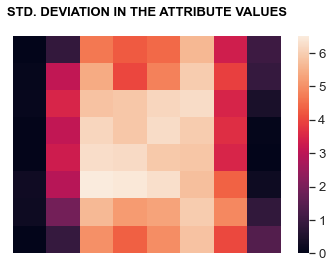

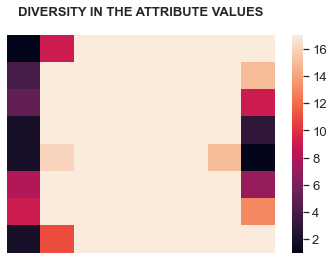

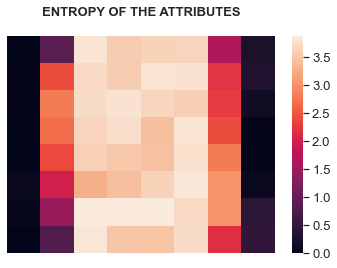

In [9]:
data = Load_Data('optdigits.tra', 'optdigits.tes')
train_data, test_data = Split(data, 0.75)

### PART 02
The following MLP architectures are trained, on the preprocessed dataset, 5 times with the learning rates as 10-1, 10-2, 10-3, 10-4 and 10-5. The length of the list denotes the number of hidden layers and the list itself consists of the number of nodes in each hidden layer (in the respective order from the input layer to the output layer).<br>
 (A)   Hidden Layers - []<br>
 (B)   Hidden Layers - [2]<br>
 (C)   Hidden Layers - [6]<br>
 (D)   Hidden Layers - [2, 3]<br>
 (E)   Hidden Layers - [3, 2]<br>

Train 5 MLP models for each of the above architectures, with each one of the above 5 learning rates (25 models in total). Report the various details related to training like training time and number of epochs. Finally evaluate each of the models post-training on the training set and test set and report their respective accuracies and losses.

In [13]:
__best_lr_for_mlp_architectures__ = dict()
__train_accuracies__ = dict()
__test_accuracies__ = dict()

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.1
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.1
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 25
 • TRAINING TIME : 0.131 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 3.07463
 • STOPPING TRAIN ACCURACY : 95.670 %
 • STOPPING VALIDATION ACCURACY : 95.848 %

 >> TRAINING PROGRESS


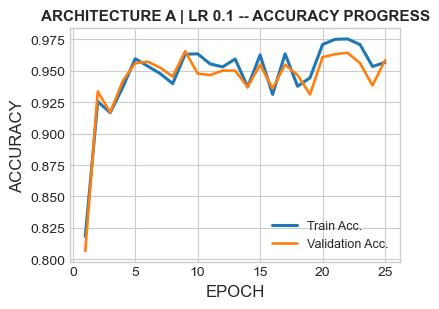

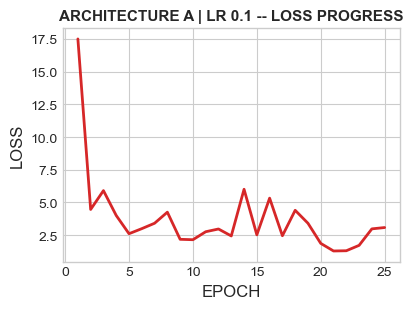


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 95.706 %
 • TEST ACCURACY : 93.665 %
 • TRAIN LOSS : 3.24242
 • TEST LOSS : 4.94064

 >> MODEL TESTING - CONFUSION MATRICES


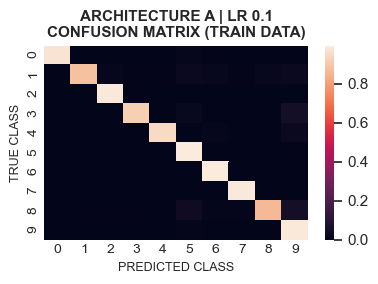

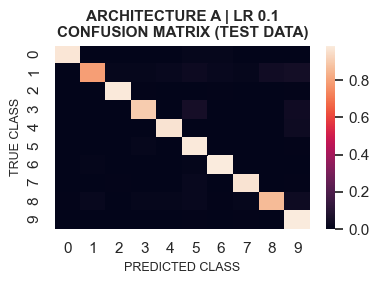

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.01
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.01
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 140
 • TRAINING TIME : 0.715 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 0.05690
 • STOPPING TRAIN ACCURACY : 98.754 %
 • STOPPING VALIDATION ACCURACY : 95.848 %

 >> TRAINING PROGRESS


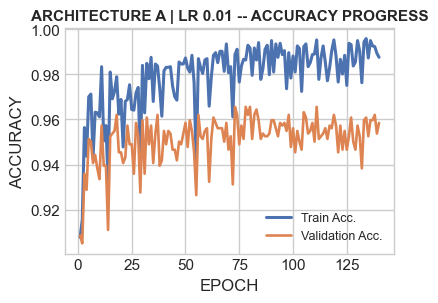

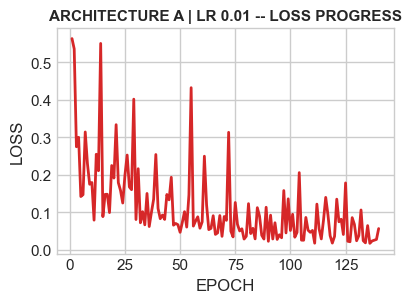


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.173 %
 • TEST ACCURACY : 96.228 %
 • TRAIN LOSS : 0.18075
 • TEST LOSS : 0.46853

 >> MODEL TESTING - CONFUSION MATRICES


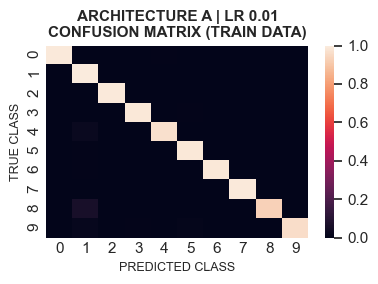

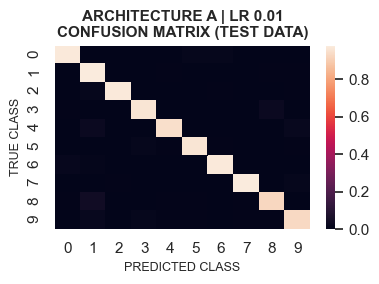

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 258
 • TRAINING TIME : 1.310 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 0.02009
 • STOPPING TRAIN ACCURACY : 99.644 %
 • STOPPING VALIDATION ACCURACY : 96.679 %

 >> TRAINING PROGRESS


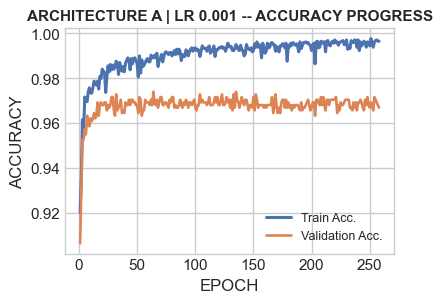

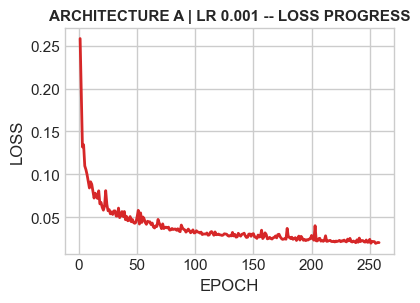


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 99.051 %
 • TEST ACCURACY : 96.940 %
 • TRAIN LOSS : 0.04211
 • TEST LOSS : 0.12488

 >> MODEL TESTING - CONFUSION MATRICES


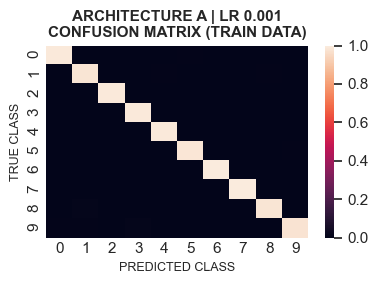

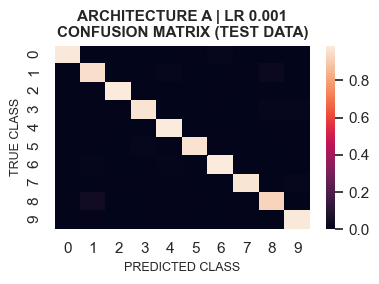

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.038 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.04498
 • STOPPING TRAIN ACCURACY : 99.021 %
 • STOPPING VALIDATION ACCURACY : 97.153 %

 >> TRAINING PROGRESS


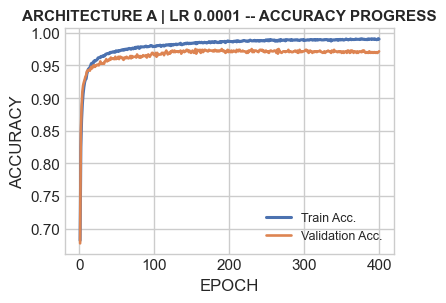

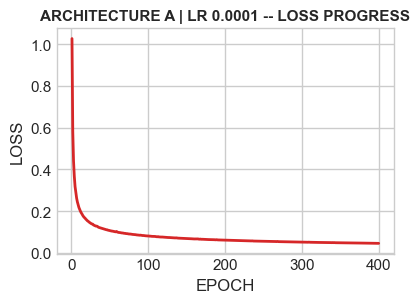


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.648 %
 • TEST ACCURACY : 97.011 %
 • TRAIN LOSS : 0.05868
 • TEST LOSS : 0.09799

 >> MODEL TESTING - CONFUSION MATRICES


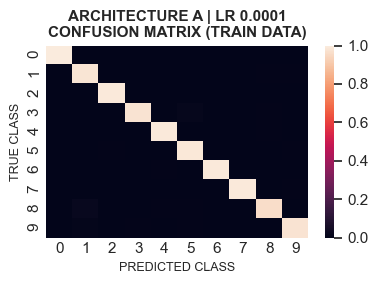

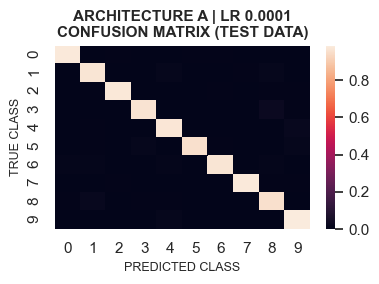

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 1e-05
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 1e-05
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.060 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.11017
 • STOPPING TRAIN ACCURACY : 96.856 %
 • STOPPING VALIDATION ACCURACY : 95.730 %

 >> TRAINING PROGRESS


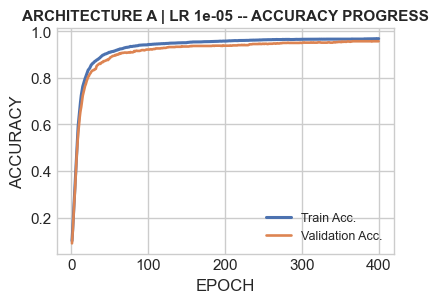

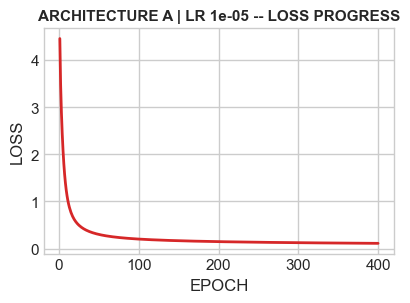


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 96.631 %
 • TEST ACCURACY : 95.587 %
 • TRAIN LOSS : 0.11937
 • TEST LOSS : 0.14934

 >> MODEL TESTING - CONFUSION MATRICES


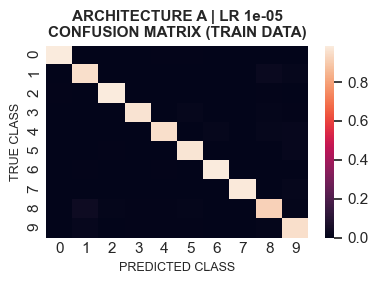

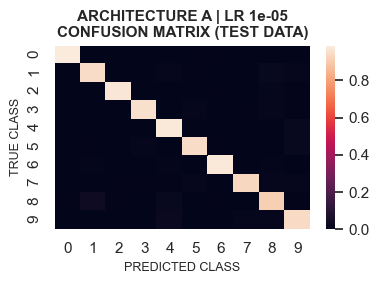

---------------------------------------------------------------------------------------------------- 



In [14]:
arch_id = 'A'
for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001] :
    print('--' * 50, '\n')
    model = Trainer(arch_id, lr, train_data)
    train_acc, test_acc = model._model_analysis_report(train_data, test_data)
    if not arch_id in __train_accuracies__ : __train_accuracies__[arch_id] = dict()
    if not arch_id in __test_accuracies__ : __test_accuracies__[arch_id] = dict()
    __train_accuracies__[arch_id][lr] = train_acc
    __test_accuracies__[arch_id][lr] = test_acc
print('--' * 50, '\n')

best_lr = None
highest_test_acc_obs = 0.0
for lr, acc in __test_accuracies__[arch_id].items() :
    if acc > highest_test_acc_obs :
        highest_test_acc_obs = acc
        best_lr = lr
__best_lr_for_mlp_architectures__[arch_id] = best_lr

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE B | LR 0.1
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2]
 • LEARNING RATE : 0.1
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 148
 • TRAINING TIME : 1.006 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 2.40891
 • STOPPING TRAIN ACCURACY : 25.326 %
 • STOPPING VALIDATION ACCURACY : 26.453 %

 >> TRAINING PROGRESS


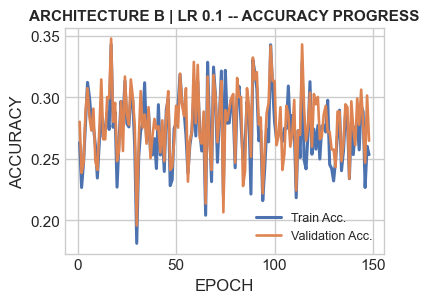

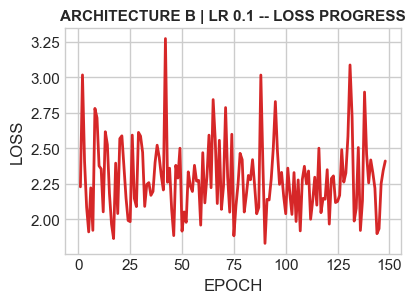


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 25.552 %
 • TEST ACCURACY : 24.911 %
 • TRAIN LOSS : 2.38130
 • TEST LOSS : 2.39130

 >> MODEL TESTING - CONFUSION MATRICES


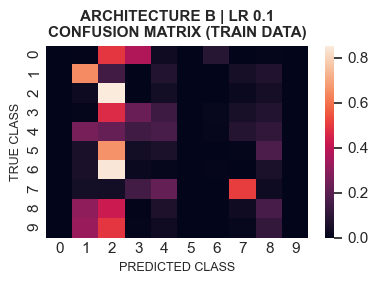

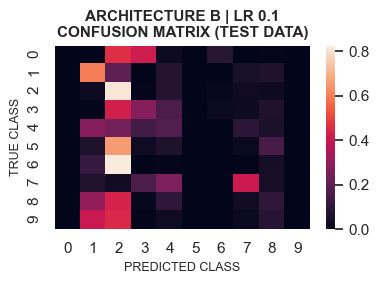

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE B | LR 0.01
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2]
 • LEARNING RATE : 0.01
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 63
 • TRAINING TIME : 0.417 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 1.86005
 • STOPPING TRAIN ACCURACY : 25.326 %
 • STOPPING VALIDATION ACCURACY : 25.623 %

 >> TRAINING PROGRESS


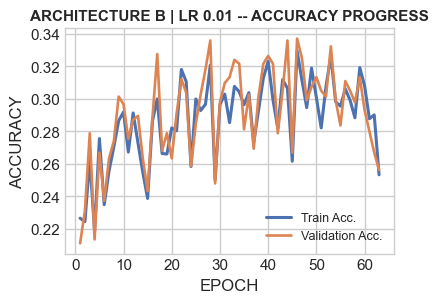

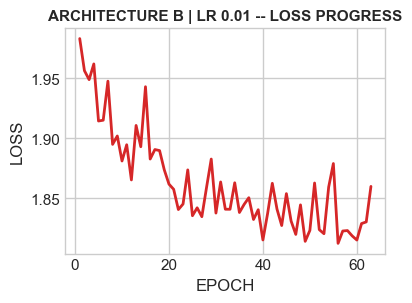


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 25.386 %
 • TEST ACCURACY : 24.911 %
 • TRAIN LOSS : 1.85413
 • TEST LOSS : 1.87943

 >> MODEL TESTING - CONFUSION MATRICES


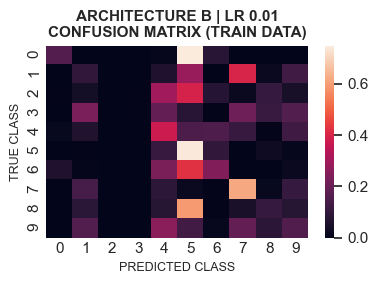

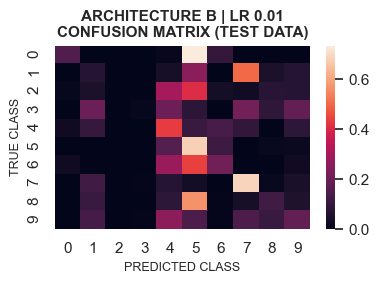

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE B | LR 0.001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2]
 • LEARNING RATE : 0.001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 219
 • TRAINING TIME : 1.435 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 1.94547
 • STOPPING TRAIN ACCURACY : 30.872 %
 • STOPPING VALIDATION ACCURACY : 31.791 %

 >> TRAINING PROGRESS


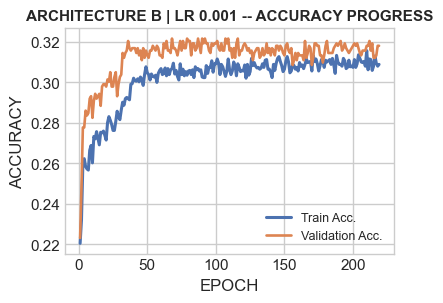

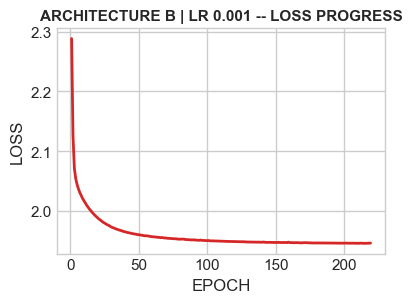


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 31.056 %
 • TEST ACCURACY : 30.391 %
 • TRAIN LOSS : 1.94052
 • TEST LOSS : 1.96083

 >> MODEL TESTING - CONFUSION MATRICES


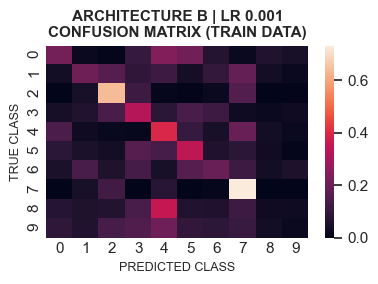

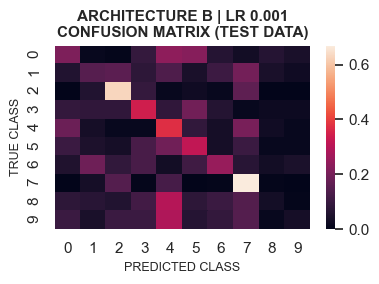

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE B | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2]
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.638 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 1.85511
 • STOPPING TRAIN ACCURACY : 33.867 %
 • STOPPING VALIDATION ACCURACY : 32.859 %

 >> TRAINING PROGRESS


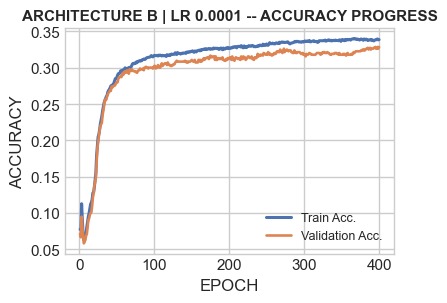

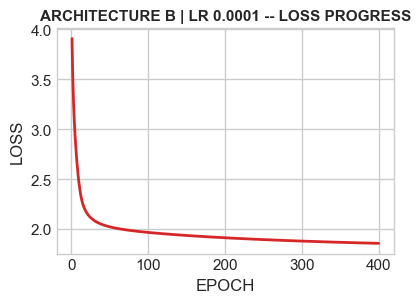


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 33.665 %
 • TEST ACCURACY : 35.445 %
 • TRAIN LOSS : 1.85955
 • TEST LOSS : 1.86181

 >> MODEL TESTING - CONFUSION MATRICES


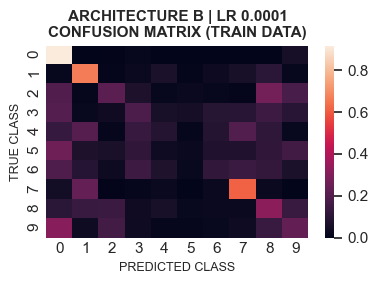

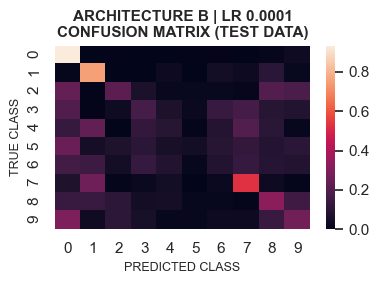

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE B | LR 1e-05
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2]
 • LEARNING RATE : 1e-05
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 19
 • TRAINING TIME : 0.124 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 2.52213
 • STOPPING TRAIN ACCURACY : 12.574 %
 • STOPPING VALIDATION ACCURACY : 12.337 %

 >> TRAINING PROGRESS


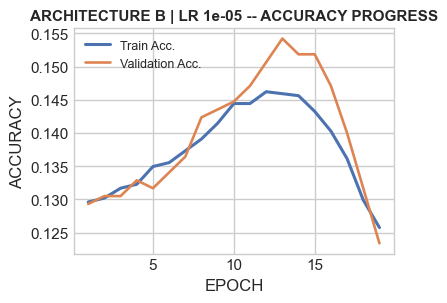

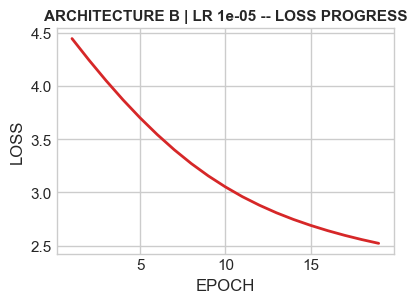


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 12.527 %
 • TEST ACCURACY : 13.310 %
 • TRAIN LOSS : 2.52232
 • TEST LOSS : 2.52341

 >> MODEL TESTING - CONFUSION MATRICES


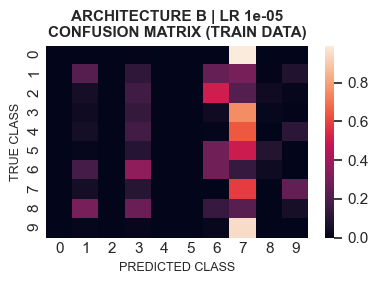

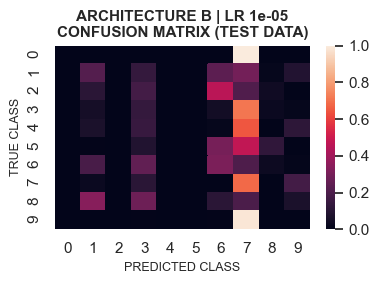

---------------------------------------------------------------------------------------------------- 



In [15]:
arch_id = 'B'
for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001] :
    print('--' * 50, '\n')
    model = Trainer(arch_id, lr, train_data)
    train_acc, test_acc = model._model_analysis_report(train_data, test_data)
    if not arch_id in __train_accuracies__ : __train_accuracies__[arch_id] = dict()
    if not arch_id in __test_accuracies__ : __test_accuracies__[arch_id] = dict()
    __train_accuracies__[arch_id][lr] = train_acc
    __test_accuracies__[arch_id][lr] = test_acc
print('--' * 50, '\n')

best_lr = None
highest_test_acc_obs = 0.0
for lr, acc in __test_accuracies__[arch_id].items() :
    if acc > highest_test_acc_obs :
        highest_test_acc_obs = acc
        best_lr = lr
__best_lr_for_mlp_architectures__[arch_id] = best_lr

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE C | LR 0.1
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [6]
 • LEARNING RATE : 0.1
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 28
 • TRAINING TIME : 0.183 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 1.75810
 • STOPPING TRAIN ACCURACY : 51.601 %
 • STOPPING VALIDATION ACCURACY : 52.076 %

 >> TRAINING PROGRESS


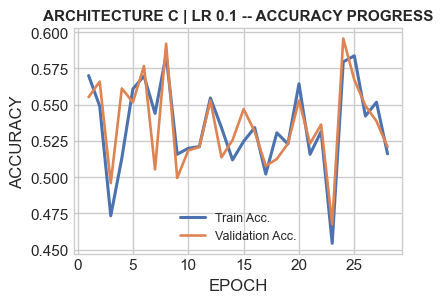

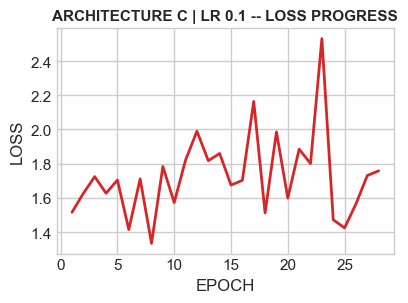


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 51.696 %
 • TEST ACCURACY : 53.381 %
 • TRAIN LOSS : 1.76245
 • TEST LOSS : 1.74457

 >> MODEL TESTING - CONFUSION MATRICES


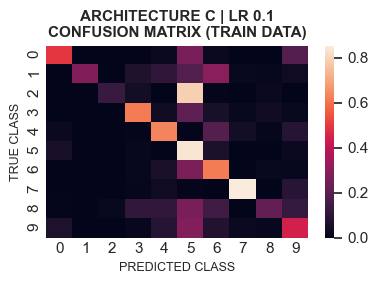

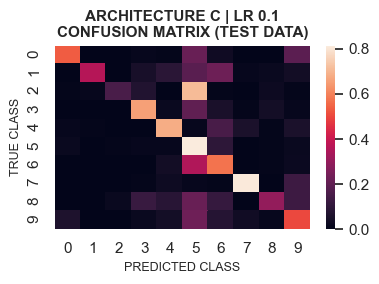

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE C | LR 0.01
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [6]
 • LEARNING RATE : 0.01
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 55
 • TRAINING TIME : 0.358 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 1.12583
 • STOPPING TRAIN ACCURACY : 63.701 %
 • STOPPING VALIDATION ACCURACY : 59.193 %

 >> TRAINING PROGRESS


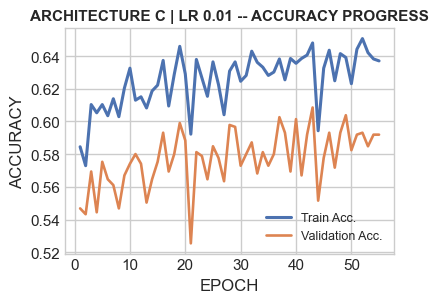

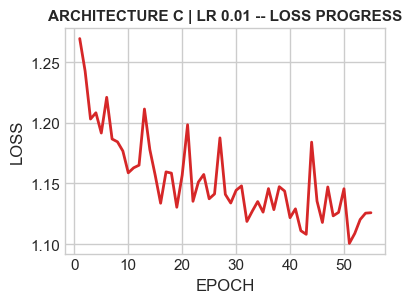


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 62.800 %
 • TEST ACCURACY : 60.071 %
 • TRAIN LOSS : 1.14713
 • TEST LOSS : 1.21000

 >> MODEL TESTING - CONFUSION MATRICES


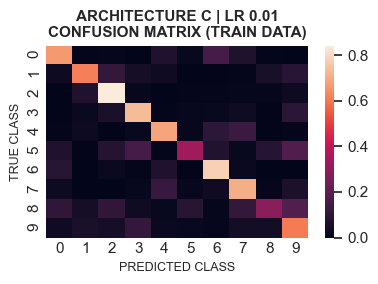

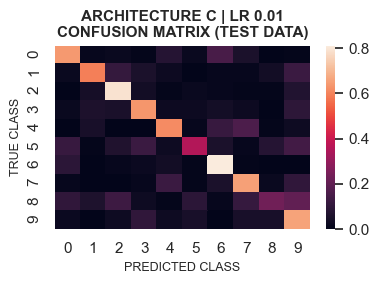

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE C | LR 0.001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [6]
 • LEARNING RATE : 0.001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 259
 • TRAINING TIME : 1.694 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 1.15817
 • STOPPING TRAIN ACCURACY : 59.490 %
 • STOPPING VALIDATION ACCURACY : 63.464 %

 >> TRAINING PROGRESS


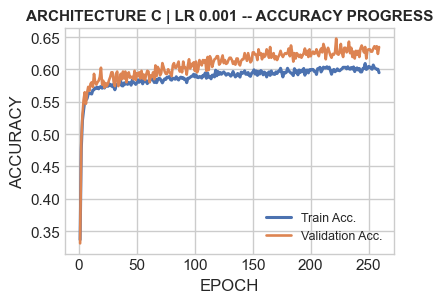

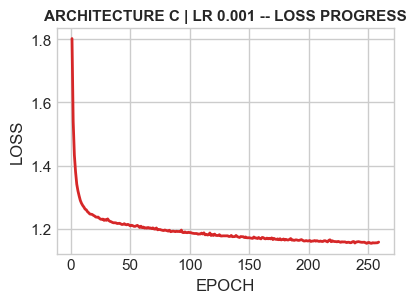


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 60.285 %
 • TEST ACCURACY : 59.288 %
 • TRAIN LOSS : 1.14123
 • TEST LOSS : 1.18146

 >> MODEL TESTING - CONFUSION MATRICES


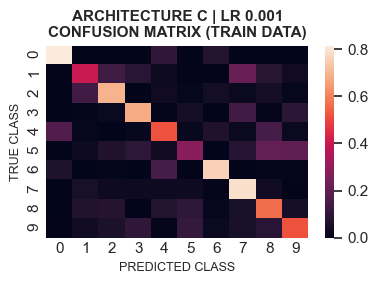

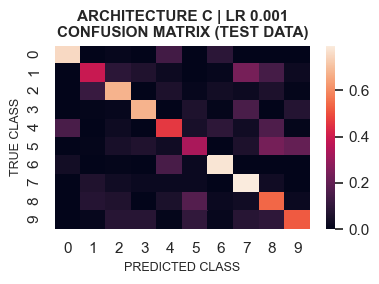

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE C | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [6]
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.615 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 1.03578
 • STOPPING TRAIN ACCURACY : 67.586 %
 • STOPPING VALIDATION ACCURACY : 64.887 %

 >> TRAINING PROGRESS


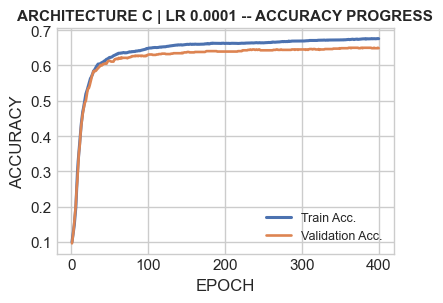

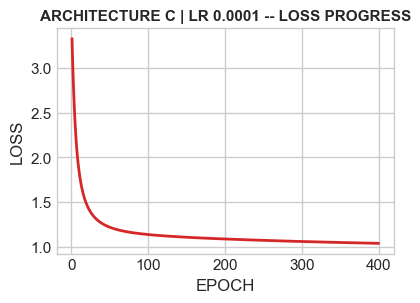


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 67.046 %
 • TEST ACCURACY : 66.192 %
 • TRAIN LOSS : 1.04393
 • TEST LOSS : 1.02238

 >> MODEL TESTING - CONFUSION MATRICES


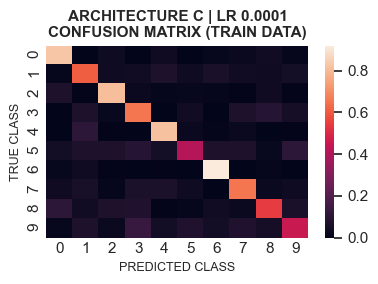

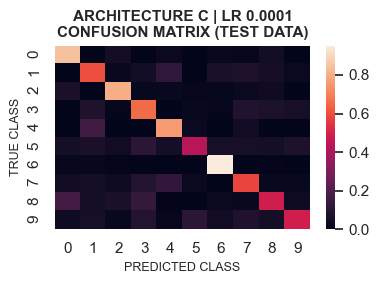

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE C | LR 1e-05
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [6]
 • LEARNING RATE : 1e-05
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.611 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 1.29044
 • STOPPING TRAIN ACCURACY : 59.727 %
 • STOPPING VALIDATION ACCURACY : 57.888 %

 >> TRAINING PROGRESS


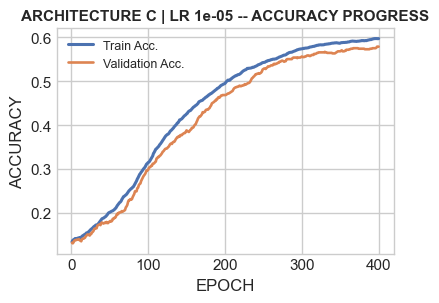

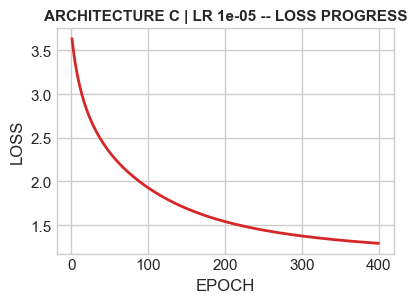


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 59.359 %
 • TEST ACCURACY : 60.498 %
 • TRAIN LOSS : 1.29493
 • TEST LOSS : 1.27350

 >> MODEL TESTING - CONFUSION MATRICES


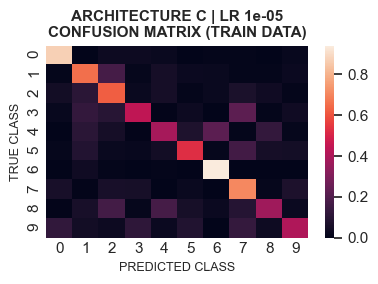

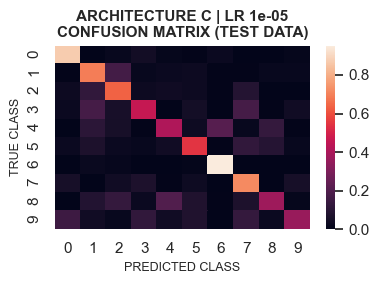

---------------------------------------------------------------------------------------------------- 



In [16]:
arch_id = 'C'
for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001] :
    print('--' * 50, '\n')
    model = Trainer(arch_id, lr, train_data)
    train_acc, test_acc = model._model_analysis_report(train_data, test_data)
    if not arch_id in __train_accuracies__ : __train_accuracies__[arch_id] = dict()
    if not arch_id in __test_accuracies__ : __test_accuracies__[arch_id] = dict()
    __train_accuracies__[arch_id][lr] = train_acc
    __test_accuracies__[arch_id][lr] = test_acc
print('--' * 50, '\n')

best_lr = None
highest_test_acc_obs = 0.0
for lr, acc in __test_accuracies__[arch_id].items() :
    if acc > highest_test_acc_obs :
        highest_test_acc_obs = acc
        best_lr = lr
__best_lr_for_mlp_architectures__[arch_id] = best_lr

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE D | LR 0.1
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2, 3]
 • LEARNING RATE : 0.1
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 89
 • TRAINING TIME : 0.712 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 2.03772
 • STOPPING TRAIN ACCURACY : 24.614 %
 • STOPPING VALIDATION ACCURACY : 21.827 %

 >> TRAINING PROGRESS


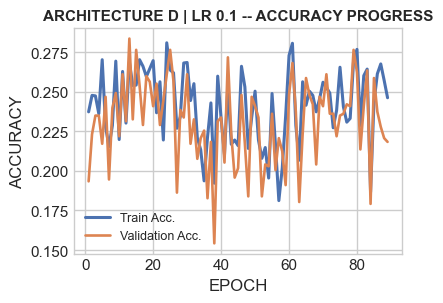

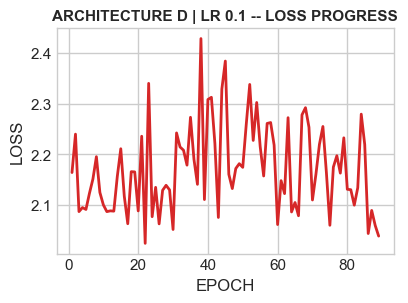


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 24.057 %
 • TEST ACCURACY : 23.772 %
 • TRAIN LOSS : 2.04321
 • TEST LOSS : 2.04290

 >> MODEL TESTING - CONFUSION MATRICES


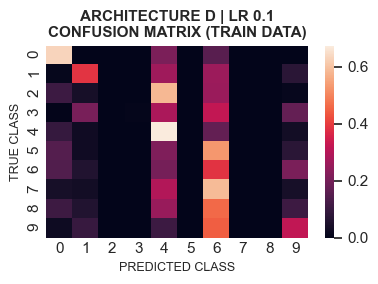

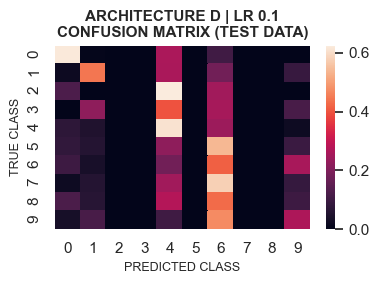

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE D | LR 0.01
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2, 3]
 • LEARNING RATE : 0.01
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 182
 • TRAINING TIME : 1.474 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 1.61253
 • STOPPING TRAIN ACCURACY : 40.095 %
 • STOPPING VALIDATION ACCURACY : 38.553 %

 >> TRAINING PROGRESS


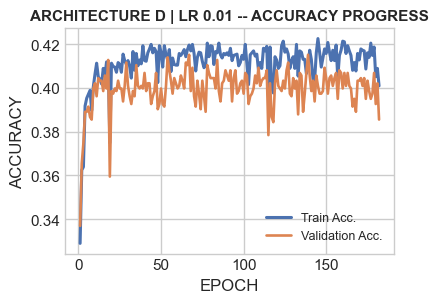

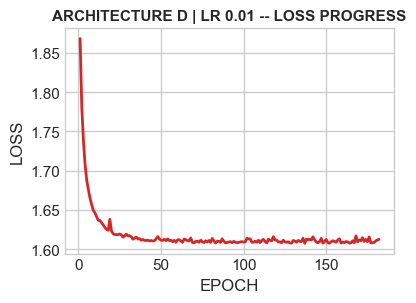


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 39.786 %
 • TEST ACCURACY : 40.498 %
 • TRAIN LOSS : 1.61620
 • TEST LOSS : 1.61429

 >> MODEL TESTING - CONFUSION MATRICES


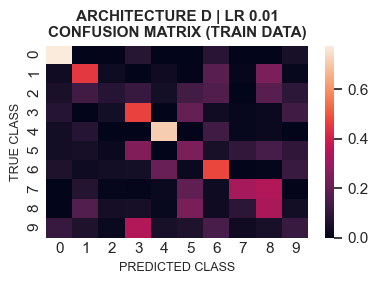

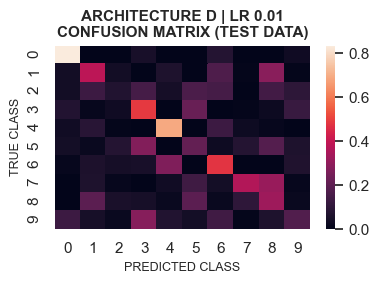

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE D | LR 0.001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2, 3]
 • LEARNING RATE : 0.001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 195
 • TRAINING TIME : 1.576 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 1.88739
 • STOPPING TRAIN ACCURACY : 31.168 %
 • STOPPING VALIDATION ACCURACY : 32.384 %

 >> TRAINING PROGRESS


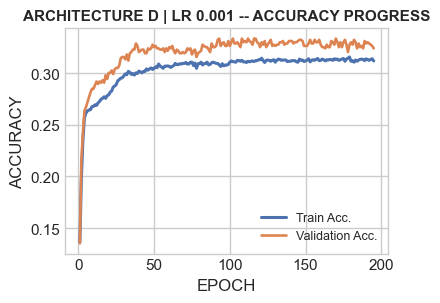

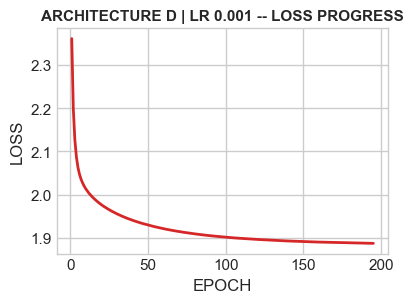


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 31.412 %
 • TEST ACCURACY : 32.242 %
 • TRAIN LOSS : 1.89160
 • TEST LOSS : 1.90526

 >> MODEL TESTING - CONFUSION MATRICES


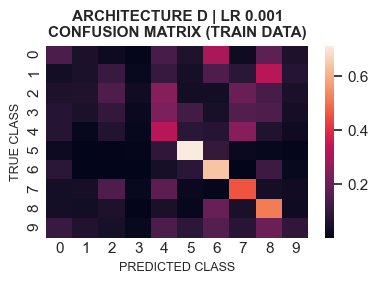

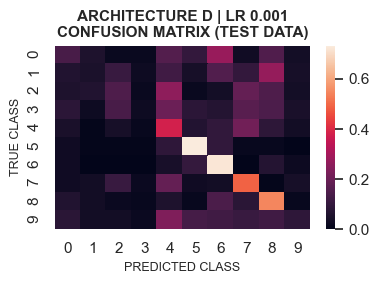

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE D | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2, 3]
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 3.226 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 1.95640
 • STOPPING TRAIN ACCURACY : 25.860 %
 • STOPPING VALIDATION ACCURACY : 22.183 %

 >> TRAINING PROGRESS


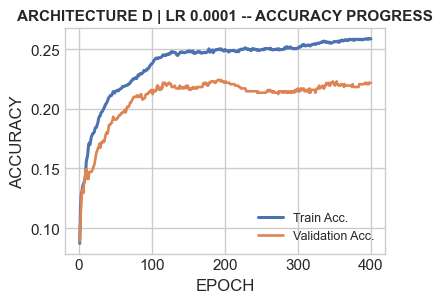

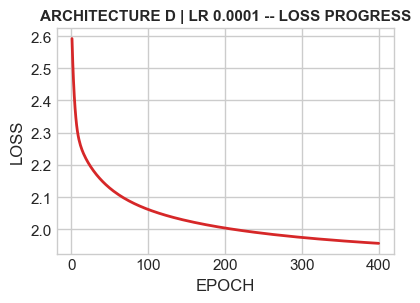


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 25.125 %
 • TEST ACCURACY : 24.128 %
 • TRAIN LOSS : 1.96389
 • TEST LOSS : 1.97660

 >> MODEL TESTING - CONFUSION MATRICES


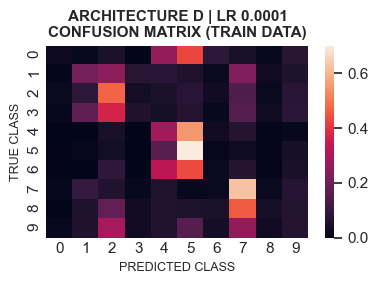

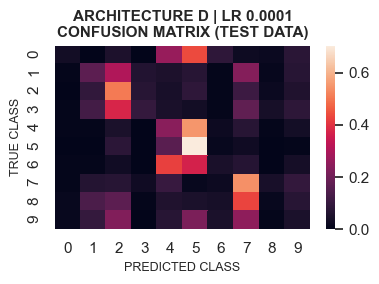

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE D | LR 1e-05
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2, 3]
 • LEARNING RATE : 1e-05
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 36
 • TRAINING TIME : 0.286 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 2.39792
 • STOPPING TRAIN ACCURACY : 16.815 %
 • STOPPING VALIDATION ACCURACY : 16.251 %

 >> TRAINING PROGRESS


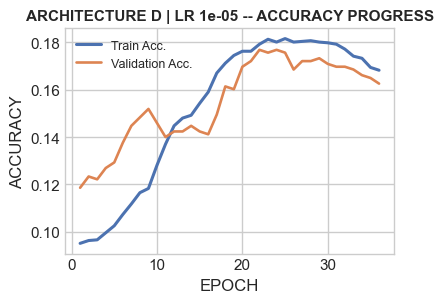

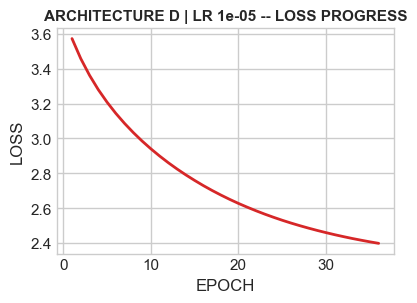


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 16.702 %
 • TEST ACCURACY : 15.231 %
 • TRAIN LOSS : 2.39823
 • TEST LOSS : 2.41872

 >> MODEL TESTING - CONFUSION MATRICES


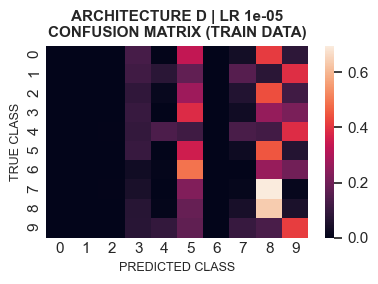

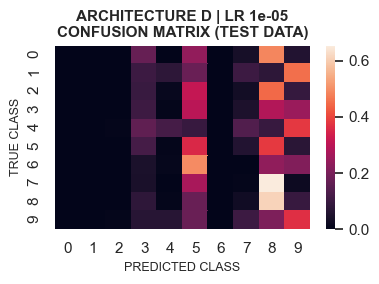

---------------------------------------------------------------------------------------------------- 



In [17]:
arch_id = 'D'
for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001] :
    print('--' * 50, '\n')
    model = Trainer(arch_id, lr, train_data)
    train_acc, test_acc = model._model_analysis_report(train_data, test_data)
    if not arch_id in __train_accuracies__ : __train_accuracies__[arch_id] = dict()
    if not arch_id in __test_accuracies__ : __test_accuracies__[arch_id] = dict()
    __train_accuracies__[arch_id][lr] = train_acc
    __test_accuracies__[arch_id][lr] = test_acc
print('--' * 50, '\n')

best_lr = None
highest_test_acc_obs = 0.0
for lr, acc in __test_accuracies__[arch_id].items() :
    if acc > highest_test_acc_obs :
        highest_test_acc_obs = acc
        best_lr = lr
__best_lr_for_mlp_architectures__[arch_id] = best_lr

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE E | LR 0.1
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [3, 2]
 • LEARNING RATE : 0.1
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 205
 • TRAINING TIME : 1.631 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 2.00423
 • STOPPING TRAIN ACCURACY : 21.619 %
 • STOPPING VALIDATION ACCURACY : 22.301 %

 >> TRAINING PROGRESS


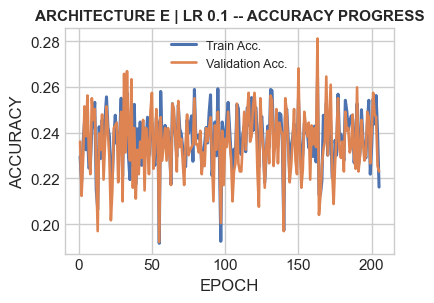

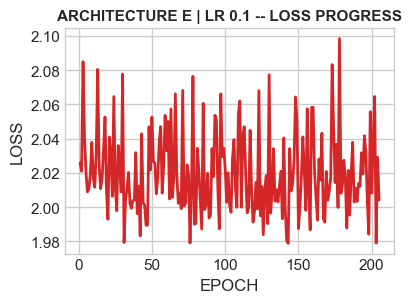


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 21.756 %
 • TEST ACCURACY : 21.708 %
 • TRAIN LOSS : 2.00306
 • TEST LOSS : 1.99366

 >> MODEL TESTING - CONFUSION MATRICES


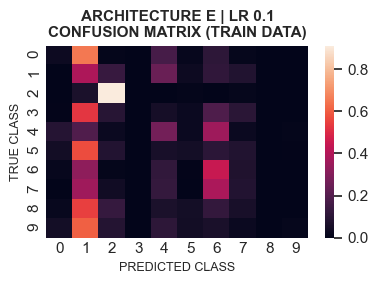

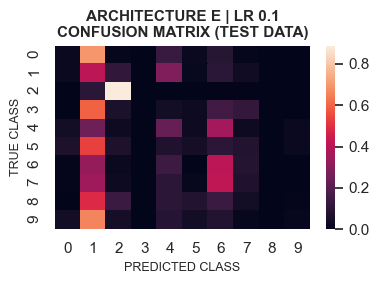

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE E | LR 0.01
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [3, 2]
 • LEARNING RATE : 0.01
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 120
 • TRAINING TIME : 0.958 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 1.84127
 • STOPPING TRAIN ACCURACY : 29.241 %
 • STOPPING VALIDATION ACCURACY : 29.300 %

 >> TRAINING PROGRESS


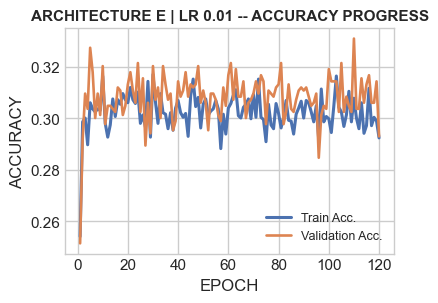

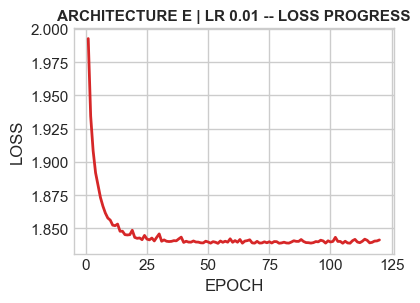


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 29.253 %
 • TEST ACCURACY : 29.680 %
 • TRAIN LOSS : 1.84567
 • TEST LOSS : 1.83232

 >> MODEL TESTING - CONFUSION MATRICES


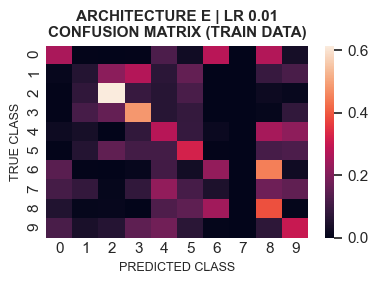

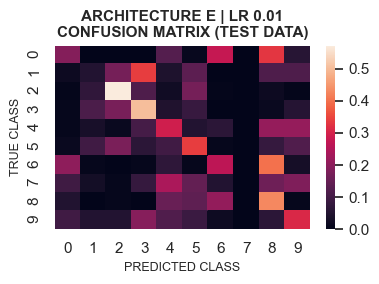

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE E | LR 0.001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [3, 2]
 • LEARNING RATE : 0.001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 270
 • TRAINING TIME : 2.146 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 1.90870
 • STOPPING TRAIN ACCURACY : 30.071 %
 • STOPPING VALIDATION ACCURACY : 30.130 %

 >> TRAINING PROGRESS


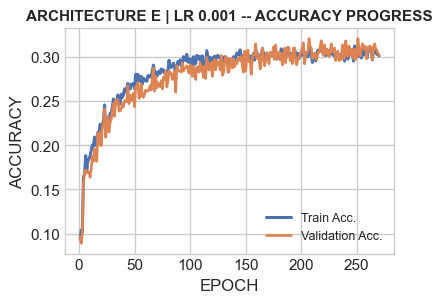

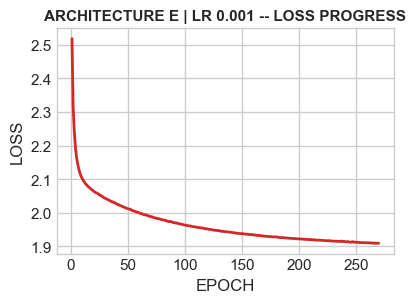


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 30.083 %
 • TEST ACCURACY : 30.463 %
 • TRAIN LOSS : 1.90318
 • TEST LOSS : 1.89050

 >> MODEL TESTING - CONFUSION MATRICES


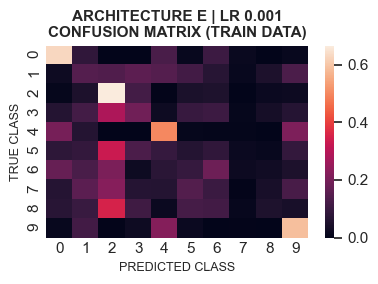

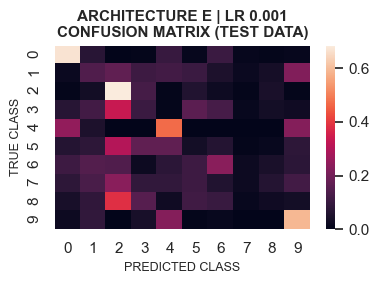

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE E | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [3, 2]
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 3.181 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 1.86678
 • STOPPING TRAIN ACCURACY : 34.104 %
 • STOPPING VALIDATION ACCURACY : 30.961 %

 >> TRAINING PROGRESS


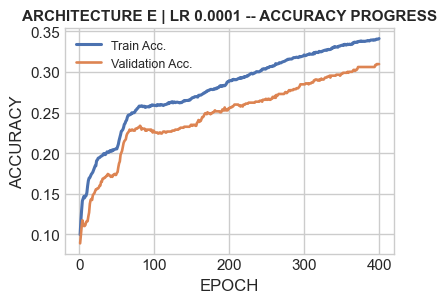

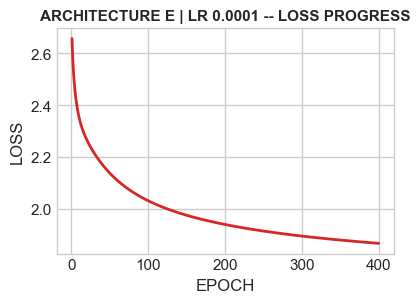


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 33.476 %
 • TEST ACCURACY : 32.598 %
 • TRAIN LOSS : 1.87046
 • TEST LOSS : 1.87454

 >> MODEL TESTING - CONFUSION MATRICES


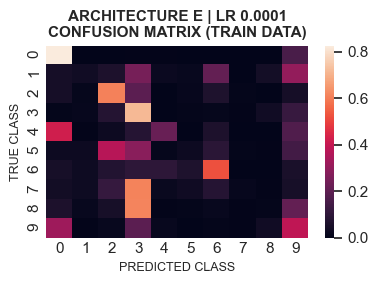

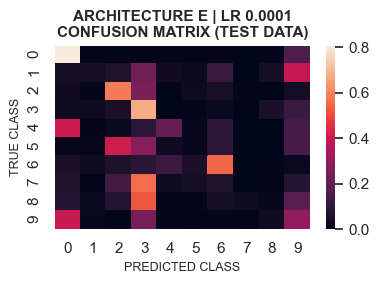

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE E | LR 1e-05
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [3, 2]
 • LEARNING RATE : 1e-05
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 3.213 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 2.02611
 • STOPPING TRAIN ACCURACY : 24.081 %
 • STOPPING VALIDATION ACCURACY : 23.606 %

 >> TRAINING PROGRESS


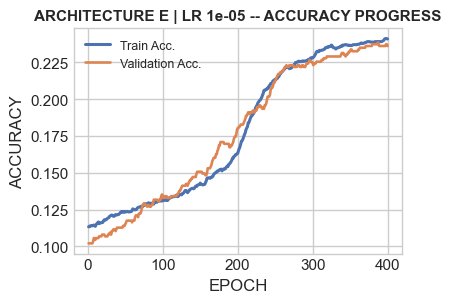

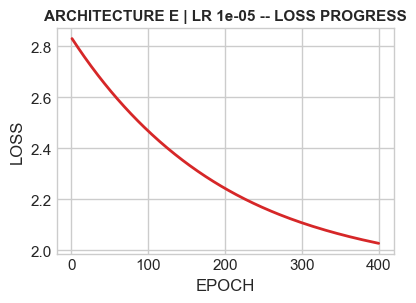


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 23.986 %
 • TEST ACCURACY : 22.989 %
 • TRAIN LOSS : 2.03159
 • TEST LOSS : 2.06213

 >> MODEL TESTING - CONFUSION MATRICES


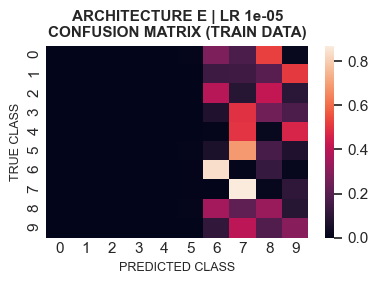

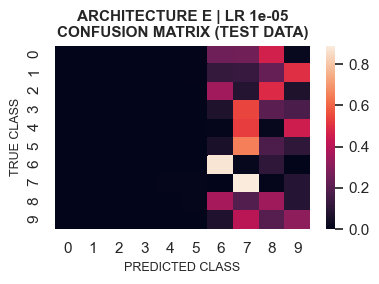

---------------------------------------------------------------------------------------------------- 



In [18]:
arch_id = 'E'
for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001] :
    print('--' * 50, '\n')
    model = Trainer(arch_id, lr, train_data)
    train_acc, test_acc = model._model_analysis_report(train_data, test_data)
    if not arch_id in __train_accuracies__ : __train_accuracies__[arch_id] = dict()
    if not arch_id in __test_accuracies__ : __test_accuracies__[arch_id] = dict()
    __train_accuracies__[arch_id][lr] = train_acc
    __test_accuracies__[arch_id][lr] = test_acc
print('--' * 50, '\n')

best_lr = None
highest_test_acc_obs = 0.0
for lr, acc in __test_accuracies__[arch_id].items() :
    if acc > highest_test_acc_obs :
        highest_test_acc_obs = acc
        best_lr = lr
__best_lr_for_mlp_architectures__[arch_id] = best_lr

In [19]:
for arch in ['A', 'B', 'C', 'D', 'E'] :
    print(' Best learning rate for Architecture', arch, ':', __best_lr_for_mlp_architectures__[arch])

 Best learning rate for Architecture A : 0.0001
 Best learning rate for Architecture B : 0.0001
 Best learning rate for Architecture C : 0.0001
 Best learning rate for Architecture D : 0.01
 Best learning rate for Architecture E : 0.0001


In [20]:
for arch in ['A', 'B', 'C', 'D', 'E'] :
    print('\n +++ ACCURACIES ON TRAIN SET FOR ARCHITECTURE', arch, '+++')
    for lr in range(1, 6) :
        print('   > LR = 1e-' + str(lr), ':', round(__train_accuracies__[arch][10**-lr], 4), '%')


 +++ ACCURACIES ON TRAIN SET FOR ARCHITECTURE A +++
   > LR = 1e-1 : 95.7058 %
   > LR = 1e-2 : 98.1732 %
   > LR = 1e-3 : 99.051 %
   > LR = 1e-4 : 98.6477 %
   > LR = 1e-5 : 96.6311 %

 +++ ACCURACIES ON TRAIN SET FOR ARCHITECTURE B +++
   > LR = 1e-1 : 25.5516 %
   > LR = 1e-2 : 25.3855 %
   > LR = 1e-3 : 31.0558 %
   > LR = 1e-4 : 33.6655 %
   > LR = 1e-5 : 12.5267 %

 +++ ACCURACIES ON TRAIN SET FOR ARCHITECTURE C +++
   > LR = 1e-1 : 51.6963 %
   > LR = 1e-2 : 62.7995 %
   > LR = 1e-3 : 60.2847 %
   > LR = 1e-4 : 67.0463 %
   > LR = 1e-5 : 59.3594 %

 +++ ACCURACIES ON TRAIN SET FOR ARCHITECTURE D +++
   > LR = 1e-1 : 24.0569 %
   > LR = 1e-2 : 39.7865 %
   > LR = 1e-3 : 31.4116 %
   > LR = 1e-4 : 25.1246 %
   > LR = 1e-5 : 16.7023 %

 +++ ACCURACIES ON TRAIN SET FOR ARCHITECTURE E +++
   > LR = 1e-1 : 21.7556 %
   > LR = 1e-2 : 29.2527 %
   > LR = 1e-3 : 30.083 %
   > LR = 1e-4 : 33.4757 %
   > LR = 1e-5 : 23.9858 %


In [21]:
for arch in ['A', 'B', 'C', 'D', 'E'] :
    print('\n +++ ACCURACIES ON TEST SET FOR ARCHITECTURE', arch, '+++')
    for lr in range(1, 6) :
        print('   > LR = 1e-' + str(lr), ':', round(__test_accuracies__[arch][10**-lr], 4), '%')


 +++ ACCURACIES ON TEST SET FOR ARCHITECTURE A +++
   > LR = 1e-1 : 93.6655 %
   > LR = 1e-2 : 96.2278 %
   > LR = 1e-3 : 96.9395 %
   > LR = 1e-4 : 97.0107 %
   > LR = 1e-5 : 95.5872 %

 +++ ACCURACIES ON TEST SET FOR ARCHITECTURE B +++
   > LR = 1e-1 : 24.911 %
   > LR = 1e-2 : 24.911 %
   > LR = 1e-3 : 30.3915 %
   > LR = 1e-4 : 35.4448 %
   > LR = 1e-5 : 13.3096 %

 +++ ACCURACIES ON TEST SET FOR ARCHITECTURE C +++
   > LR = 1e-1 : 53.3808 %
   > LR = 1e-2 : 60.0712 %
   > LR = 1e-3 : 59.2883 %
   > LR = 1e-4 : 66.1922 %
   > LR = 1e-5 : 60.4982 %

 +++ ACCURACIES ON TEST SET FOR ARCHITECTURE D +++
   > LR = 1e-1 : 23.7722 %
   > LR = 1e-2 : 40.4982 %
   > LR = 1e-3 : 32.242 %
   > LR = 1e-4 : 24.1281 %
   > LR = 1e-5 : 15.2313 %

 +++ ACCURACIES ON TEST SET FOR ARCHITECTURE E +++
   > LR = 1e-1 : 21.7082 %
   > LR = 1e-2 : 29.6797 %
   > LR = 1e-3 : 30.4626 %
   > LR = 1e-4 : 32.5979 %
   > LR = 1e-5 : 22.9893 %


### PART 03
For the results obtained in the second part, graphs of accuracy of each model architecture v/s learning rate and accuracy for each learning rate v/s architecture are plotted.

Plot the accuracy of the trained model on the test set v/s the model architecture (number of hidden layers and their sizes), for each learning rate on the same graph. Plot the accuracy of the trained model on the test set v/s the learning rate, for each model architecture on the same graph. Infer from the results the dependence of the quality of the MLP models on the model architecture and try to explain it.

In [22]:
layers = {
        'A' : [],
        'B' : [2],
        'C' : [6],
        'D' : [2, 3],
        'E' : [3, 2]
}

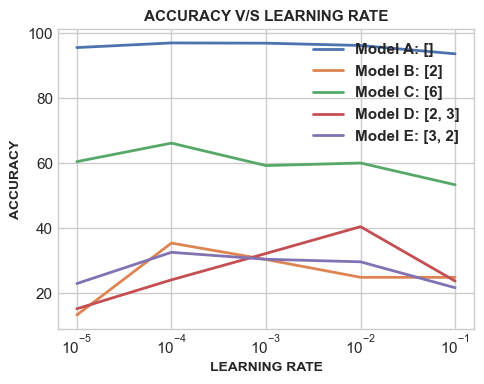

In [23]:
fontsize = 10
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot()
for arch in ['A', 'B', 'C', 'D', 'E'] :
    X = list(__test_accuracies__[arch].keys())
    Y = list(__test_accuracies__[arch].values())
    ax.plot(X, Y, linewidth = 2)

ax.set_xscale('log')
plt.xlabel('LEARNING RATE', fontsize=fontsize, fontweight='bold')
plt.ylabel('ACCURACY', fontsize=fontsize, fontweight='bold')
plt.legend(['Model ' + arch + ': ' + str(layers[arch]) for arch in ['A', 'B', 'C', 'D', 'E']], 
           fontsize = 9, prop={'weight':'bold'}, loc="upper right")
plt.title('ACCURACY V/S LEARNING RATE', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('PART3_acc_vs_lr.png')
plt.show()

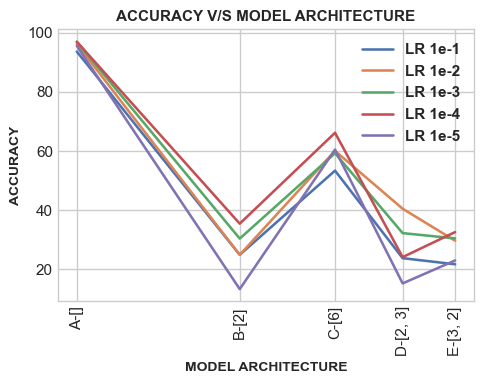

In [24]:
fontsize = 10
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot()
for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001] :
    X = ['A', 'B', 'C', 'D', 'E']
    Y = [__test_accuracies__[arch][lr] for arch in X]
    ax.plot(list(range(1,6)), Y, linewidth = 1.85)

plt.xlabel('MODEL ARCHITECTURE', fontsize=fontsize, fontweight='bold')
plt.ylabel('ACCURACY', fontsize=fontsize, fontweight='bold')
plt.legend(['LR 1e-' + str(lr) for lr in [1, 2, 3, 4, 5]], fontsize = 9, prop={'weight':'bold'})
plt.title('ACCURACY V/S MODEL ARCHITECTURE', fontsize = 11, fontweight = 'bold')

xticks = [arch + '-' + str(layers[arch]) for arch in ['A', 'B', 'C', 'D', 'E']]
plt.xticks(list(range(1,6)), xticks, rotation = 'vertical')
plt.tight_layout()
plt.savefig('PART3_acc_vs_model.png')
plt.show()

### PART 04
The best architecture and its optimal learning rate as found from the results of the second part are reported. For an MLP classifier with this best architecture and optimal learning rate, the most suitable values of the other hyperparameters (as specified in the first part) are found and reported. 

Train MLP classification models with the best architecture found in the second part and its optimal learning rate by varying the following hyperparameters with the corresponding values and keeping the other hyperparameters constant at their default values.<br>
*BATCH SIZE* - [ 2 , 4 , 8 , 16 , 32 , 64 , 128 ]<br>
*MOMENTUM* - [ 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.0 ]<br>
*EARLY  STOPPING  TOL* - [ 1 , 2 , 3 , 4 , 5 , 6 ]<br>
*TRAINING  EPOCHS* - [ 1 to 800 ]

Evaluate each of the above models (20 in total) on the train and test set and deduce the most suitable hyperparameters for the best architecture of the MLP classifier and its corresponding best learning rate. Justify the trends in the performances of the models with varying hyperparameters.

In [25]:
__best_architecture_found__ = None
__best_learning_rate_found__ = None
layers = {
        'A' : [],
        'B' : [2],
        'C' : [6],
        'D' : [2, 3],
        'E' : [3, 2]
}

highest_test_acc_obs = 0.0
for arch in __test_accuracies__ :
    for lr in __test_accuracies__[arch] :
        if highest_test_acc_obs < __test_accuracies__[arch][lr] :
            highest_test_acc_obs = __test_accuracies__[arch][lr]
            __best_architecture_found__ = arch
            __best_learning_rate_found__ = lr

print(' Best model architecture : Architecture', __best_architecture_found__)

 Best model architecture : Architecture A


---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 2
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 92
 • TRAINING TIME : 0.768 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 0.04228
 • STOPPING TRAIN ACCURACY : 98.873 %
 • STOPPING VALIDATION ACCURACY : 97.034 %

 >> TRAINING PROGRESS


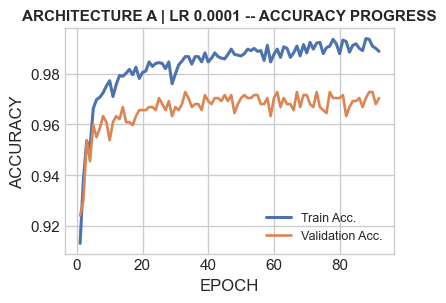

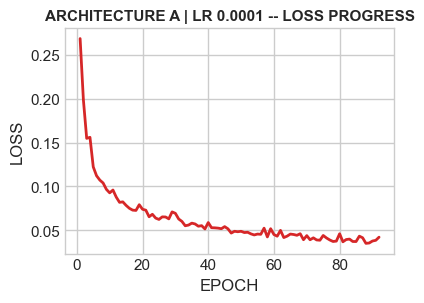


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.505 %
 • TEST ACCURACY : 96.370 %
 • TRAIN LOSS : 0.05754
 • TEST LOSS : 0.11632

 >> MODEL TESTING - CONFUSION MATRICES


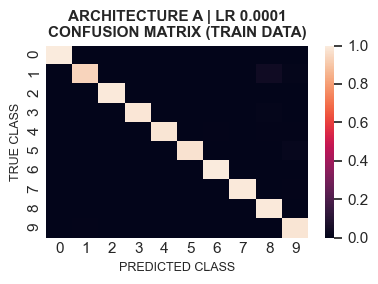

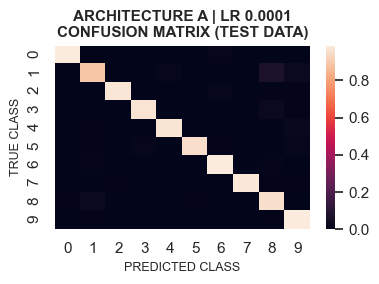

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 4
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 289
 • TRAINING TIME : 1.874 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 0.02965
 • STOPPING TRAIN ACCURACY : 99.496 %
 • STOPPING VALIDATION ACCURACY : 96.560 %

 >> TRAINING PROGRESS


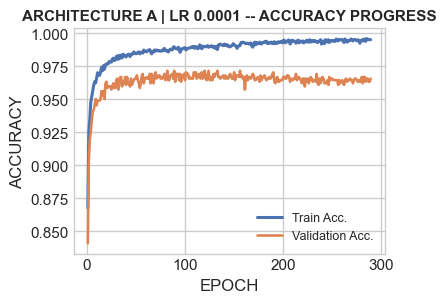

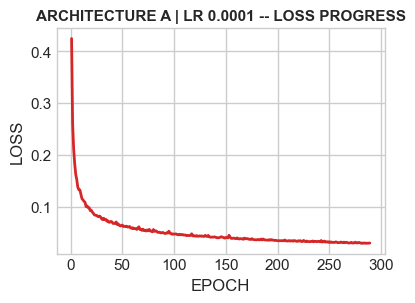


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.909 %
 • TEST ACCURACY : 96.655 %
 • TRAIN LOSS : 0.04744
 • TEST LOSS : 0.10786

 >> MODEL TESTING - CONFUSION MATRICES


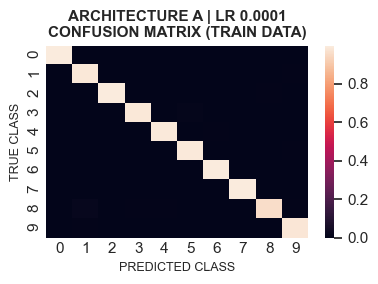

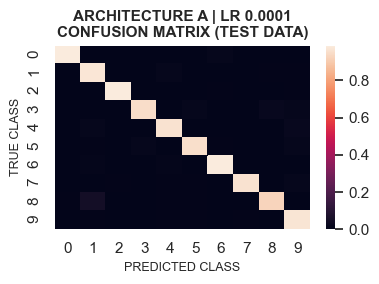

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 8
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.219 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.03353
 • STOPPING TRAIN ACCURACY : 99.288 %
 • STOPPING VALIDATION ACCURACY : 96.204 %

 >> TRAINING PROGRESS


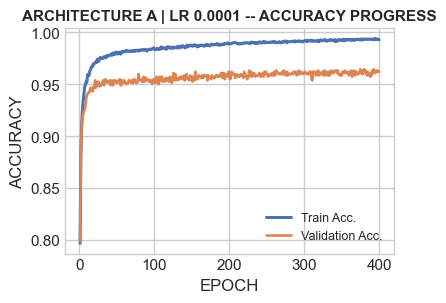

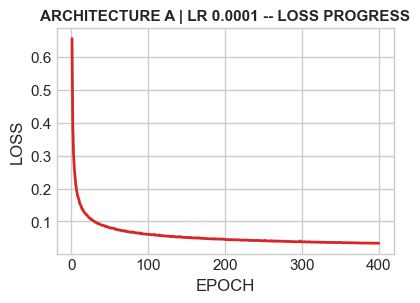


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.671 %
 • TEST ACCURACY : 97.367 %
 • TRAIN LOSS : 0.05279
 • TEST LOSS : 0.09610

 >> MODEL TESTING - CONFUSION MATRICES


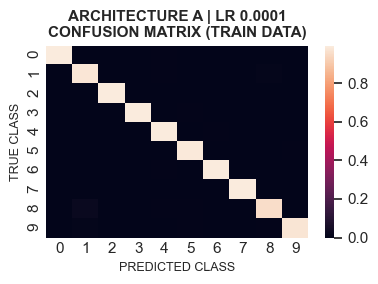

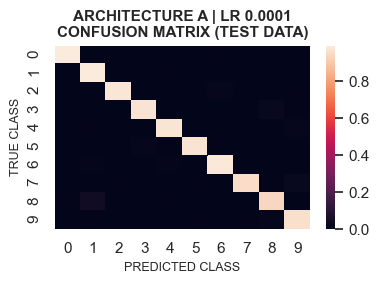

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.014 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.04592
 • STOPPING TRAIN ACCURACY : 98.873 %
 • STOPPING VALIDATION ACCURACY : 96.797 %

 >> TRAINING PROGRESS


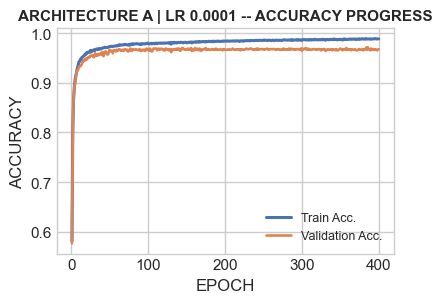

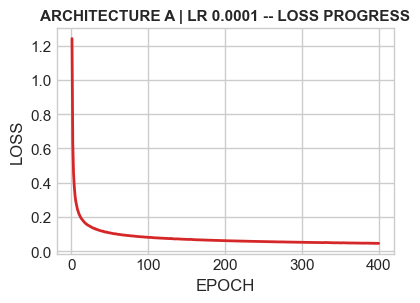


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.458 %
 • TEST ACCURACY : 96.868 %
 • TRAIN LOSS : 0.05846
 • TEST LOSS : 0.10282

 >> MODEL TESTING - CONFUSION MATRICES


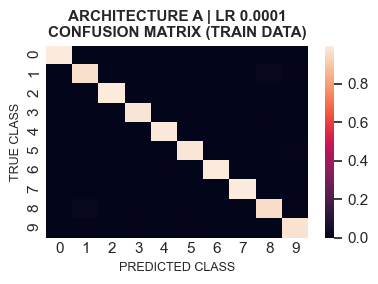

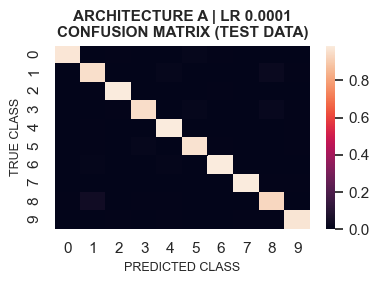

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 32
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 1.926 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.06334
 • STOPPING TRAIN ACCURACY : 98.339 %
 • STOPPING VALIDATION ACCURACY : 97.034 %

 >> TRAINING PROGRESS


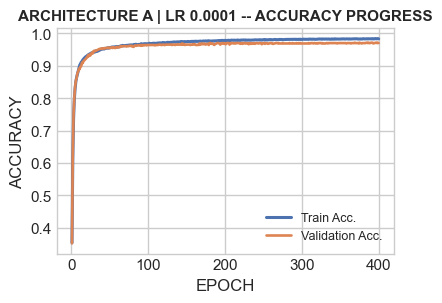

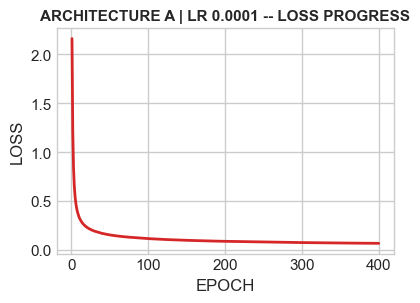


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.078 %
 • TEST ACCURACY : 96.797 %
 • TRAIN LOSS : 0.07052
 • TEST LOSS : 0.10147

 >> MODEL TESTING - CONFUSION MATRICES


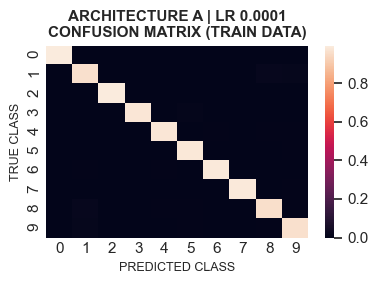

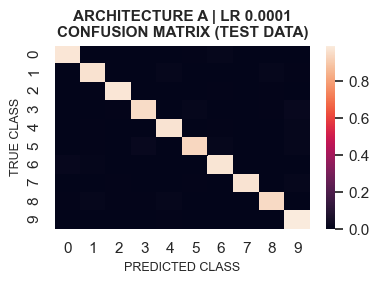

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 64
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 1.877 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.08548
 • STOPPING TRAIN ACCURACY : 97.805 %
 • STOPPING VALIDATION ACCURACY : 97.272 %

 >> TRAINING PROGRESS


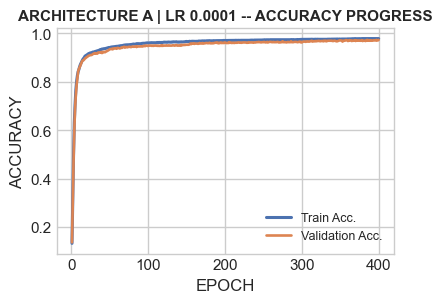

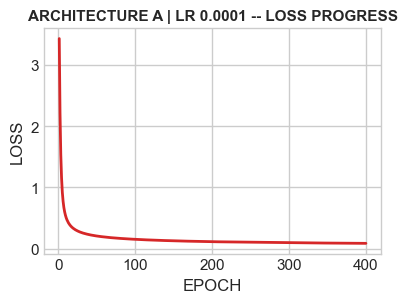


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 97.699 %
 • TEST ACCURACY : 96.726 %
 • TRAIN LOSS : 0.08890
 • TEST LOSS : 0.12018

 >> MODEL TESTING - CONFUSION MATRICES


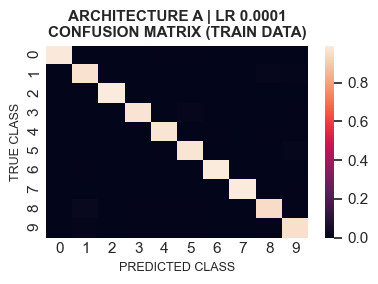

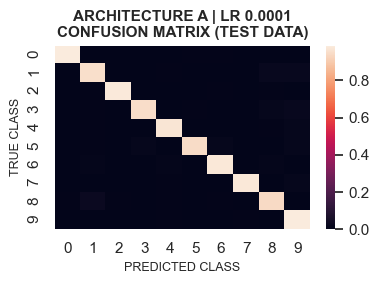

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 128
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 1.853 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.11192
 • STOPPING TRAIN ACCURACY : 96.797 %
 • STOPPING VALIDATION ACCURACY : 96.560 %

 >> TRAINING PROGRESS


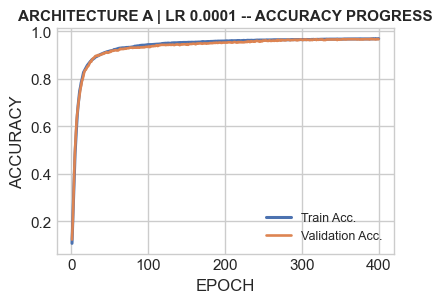

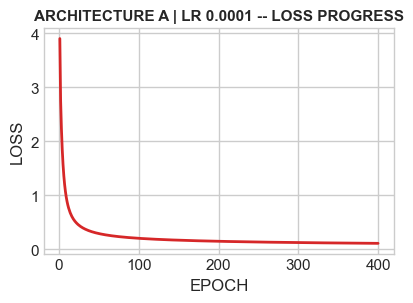


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 96.750 %
 • TEST ACCURACY : 95.801 %
 • TRAIN LOSS : 0.11568
 • TEST LOSS : 0.13644

 >> MODEL TESTING - CONFUSION MATRICES


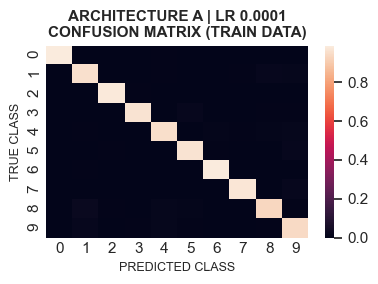

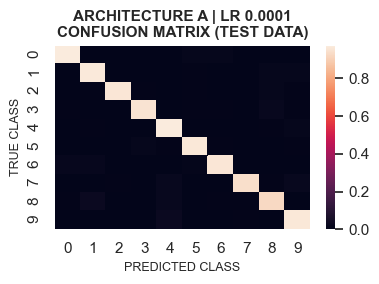

---------------------------------------------------------------------------------------------------- 



In [26]:
batch_sizes = [2, 4, 8, 16, 32, 64, 128]
highest_test_acc_obs = 0.0
__best_batch_size__ = None
for bs in batch_sizes :
    print('--' * 50, '\n')
    model = Trainer(__best_architecture_found__, __best_learning_rate_found__, 
                    train_data, batch_size = bs)
    _, test_acc = model._model_analysis_report(train_data, test_data)
    if test_acc > highest_test_acc_obs :
        highest_test_acc_obs = test_acc
        __best_batch_size__ = bs
print('--' * 50, '\n')

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.5
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 1.991 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.06430
 • STOPPING TRAIN ACCURACY : 98.488 %
 • STOPPING VALIDATION ACCURACY : 96.560 %

 >> TRAINING PROGRESS


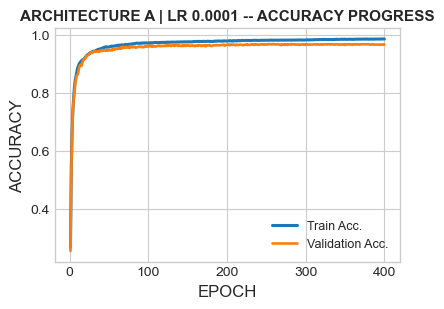

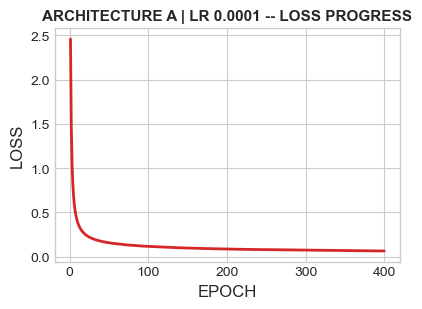


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.102 %
 • TEST ACCURACY : 96.441 %
 • TRAIN LOSS : 0.07404
 • TEST LOSS : 0.11812

 >> MODEL TESTING - CONFUSION MATRICES


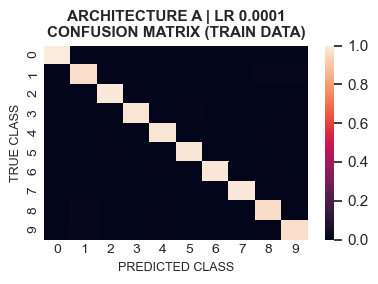

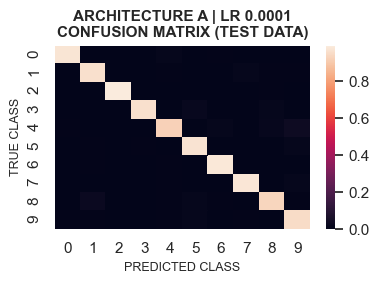

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.6
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.009 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.05712
 • STOPPING TRAIN ACCURACY : 98.665 %
 • STOPPING VALIDATION ACCURACY : 96.797 %

 >> TRAINING PROGRESS


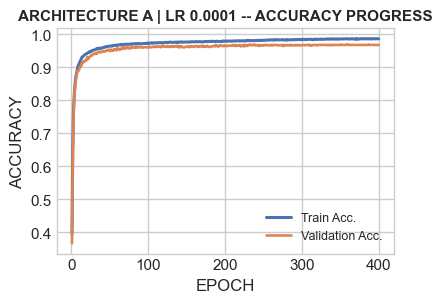

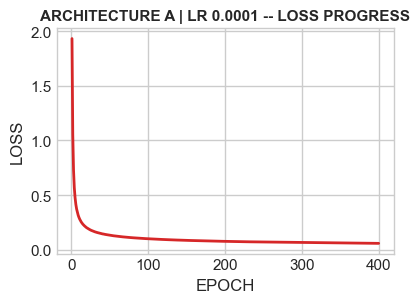


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.292 %
 • TEST ACCURACY : 96.228 %
 • TRAIN LOSS : 0.06828
 • TEST LOSS : 0.12797

 >> MODEL TESTING - CONFUSION MATRICES


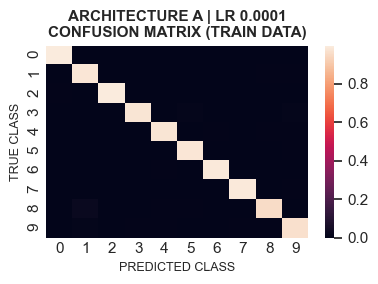

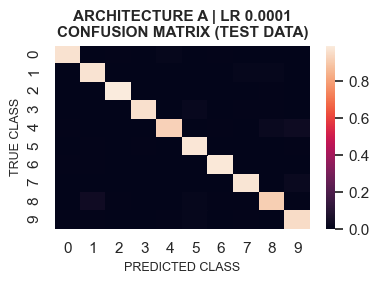

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.7
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.006 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.04932
 • STOPPING TRAIN ACCURACY : 98.814 %
 • STOPPING VALIDATION ACCURACY : 97.034 %

 >> TRAINING PROGRESS


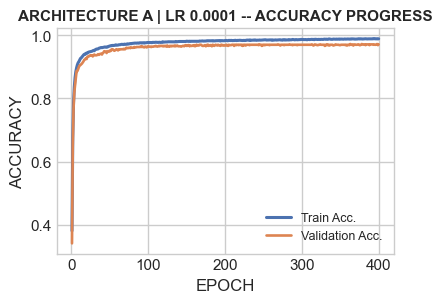

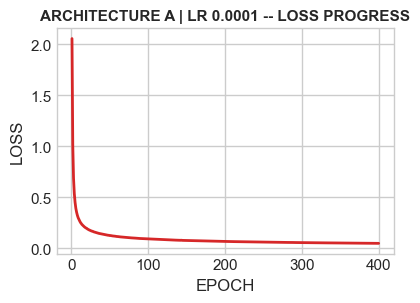


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.458 %
 • TEST ACCURACY : 96.726 %
 • TRAIN LOSS : 0.06172
 • TEST LOSS : 0.11840

 >> MODEL TESTING - CONFUSION MATRICES


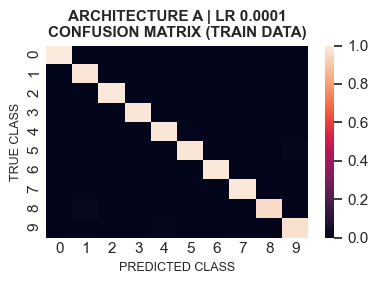

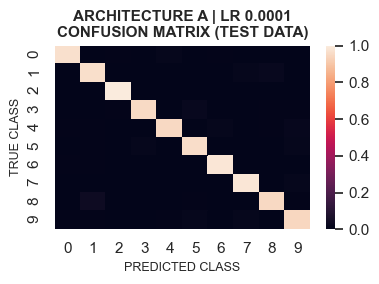

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.025 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.04507
 • STOPPING TRAIN ACCURACY : 98.932 %
 • STOPPING VALIDATION ACCURACY : 97.153 %

 >> TRAINING PROGRESS


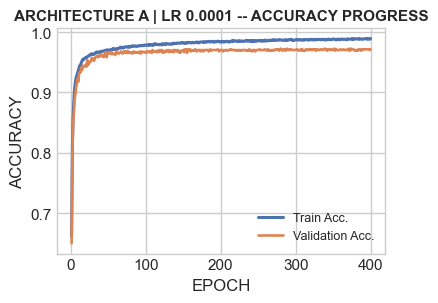

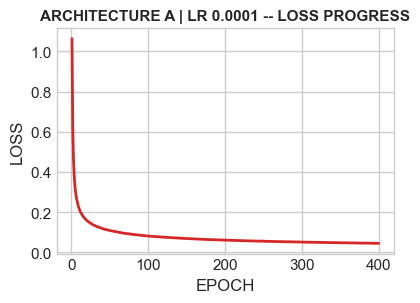


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.577 %
 • TEST ACCURACY : 96.940 %
 • TRAIN LOSS : 0.05301
 • TEST LOSS : 0.11243

 >> MODEL TESTING - CONFUSION MATRICES


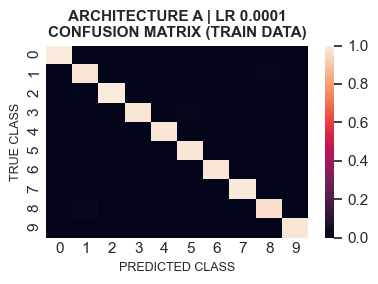

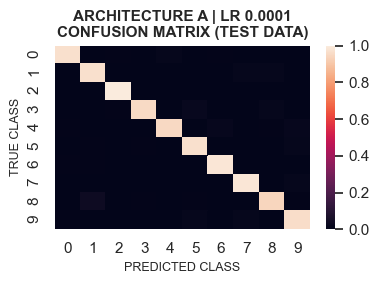

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.9
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 127
 • TRAINING TIME : 0.641 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 0.05293
 • STOPPING TRAIN ACCURACY : 98.754 %
 • STOPPING VALIDATION ACCURACY : 96.323 %

 >> TRAINING PROGRESS


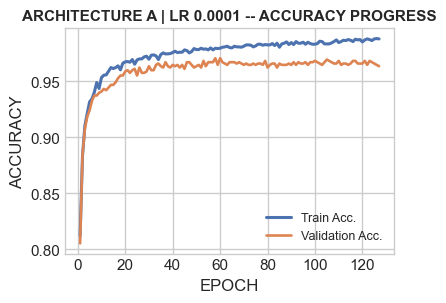

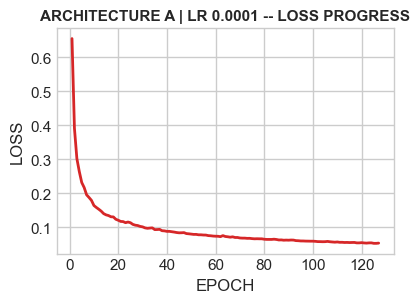


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.268 %
 • TEST ACCURACY : 96.370 %
 • TRAIN LOSS : 0.06498
 • TEST LOSS : 0.12044

 >> MODEL TESTING - CONFUSION MATRICES


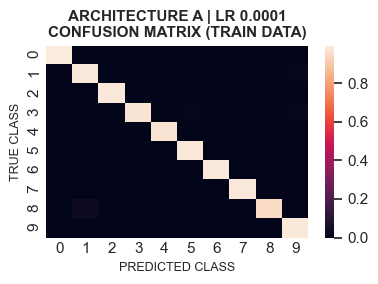

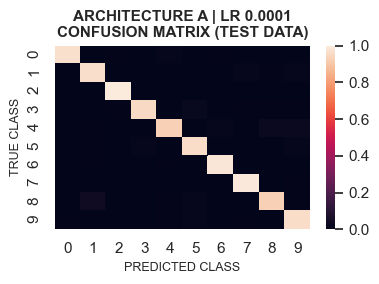

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 1.0
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 6
 • TRAINING TIME : 0.030 mins
 • STOPPING REASON : [Early Stopping] Training loss was not decreasing
 • STOPPING TRAIN LOSS : 1.73402
 • STOPPING TRAIN ACCURACY : 95.344 %
 • STOPPING VALIDATION ACCURACY : 94.781 %

 >> TRAINING PROGRESS


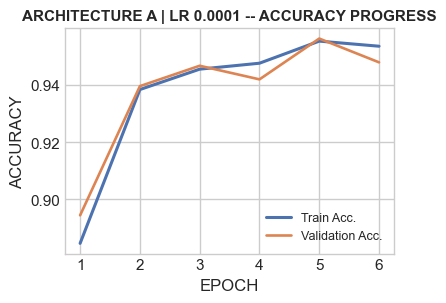

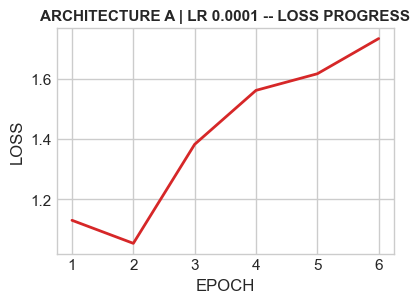


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 95.231 %
 • TEST ACCURACY : 93.737 %
 • TRAIN LOSS : 1.82476
 • TEST LOSS : 2.77624

 >> MODEL TESTING - CONFUSION MATRICES


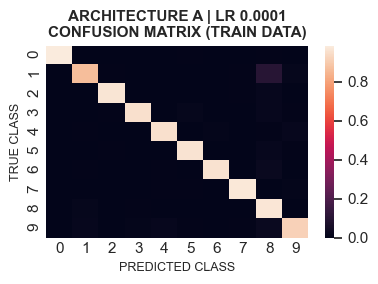

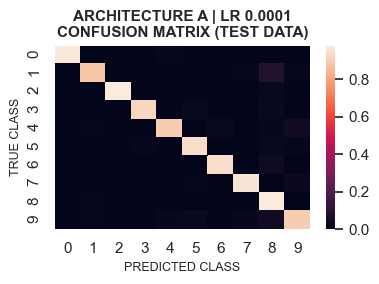

---------------------------------------------------------------------------------------------------- 



In [27]:
momentums = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
highest_test_acc_obs = 0.0
__best_momentum__ = None
for mom in momentums :
    print('--' * 50, '\n')
    model = Trainer(__best_architecture_found__, __best_learning_rate_found__, 
                    train_data, momentum = mom)
    _, test_acc = model._model_analysis_report(train_data, test_data)
    if test_acc > highest_test_acc_obs :
        highest_test_acc_obs = test_acc
        __best_momentum__ = mom
print('--' * 50, '\n')

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 1

 >> TRAINING INFORMATION
 • EPOCHS : 14
 • TRAINING TIME : 0.070 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 0.19030
 • STOPPING TRAIN ACCURACY : 94.632 %
 • STOPPING VALIDATION ACCURACY : 92.645 %

 >> TRAINING PROGRESS


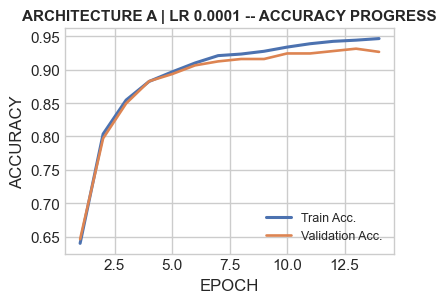

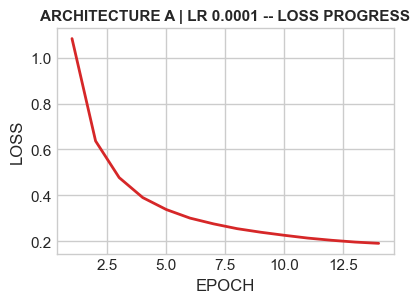


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 94.235 %
 • TEST ACCURACY : 93.523 %
 • TRAIN LOSS : 0.19930
 • TEST LOSS : 0.21725

 >> MODEL TESTING - CONFUSION MATRICES


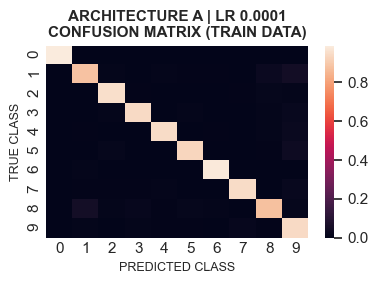

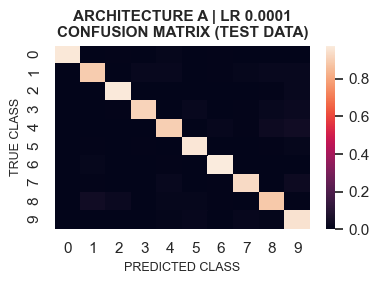

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 2

 >> TRAINING INFORMATION
 • EPOCHS : 21
 • TRAINING TIME : 0.108 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 0.15326
 • STOPPING TRAIN ACCURACY : 95.552 %
 • STOPPING VALIDATION ACCURACY : 94.781 %

 >> TRAINING PROGRESS


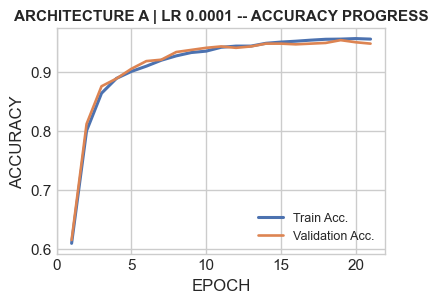

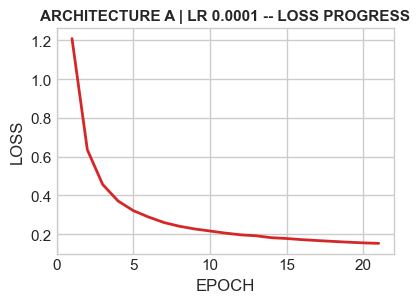


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 95.397 %
 • TEST ACCURACY : 95.018 %
 • TRAIN LOSS : 0.15647
 • TEST LOSS : 0.16910

 >> MODEL TESTING - CONFUSION MATRICES


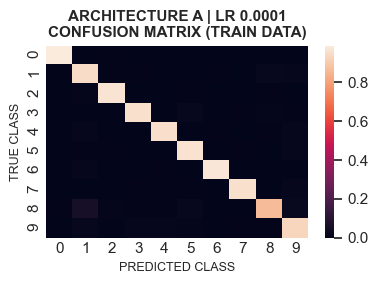

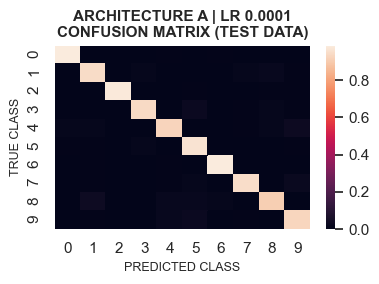

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 3

 >> TRAINING INFORMATION
 • EPOCHS : 89
 • TRAINING TIME : 0.449 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 0.08219
 • STOPPING TRAIN ACCURACY : 97.835 %
 • STOPPING VALIDATION ACCURACY : 95.848 %

 >> TRAINING PROGRESS


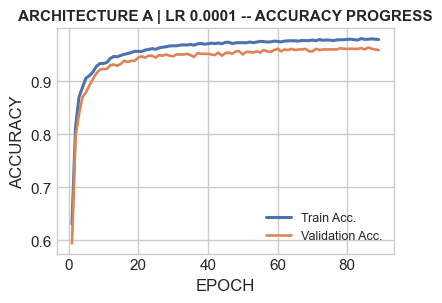

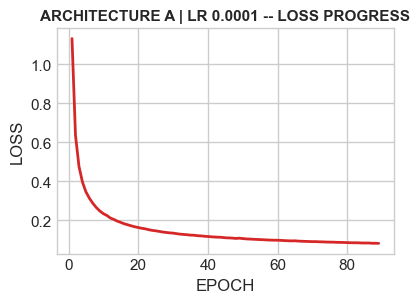


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 97.438 %
 • TEST ACCURACY : 96.299 %
 • TRAIN LOSS : 0.09294
 • TEST LOSS : 0.12856

 >> MODEL TESTING - CONFUSION MATRICES


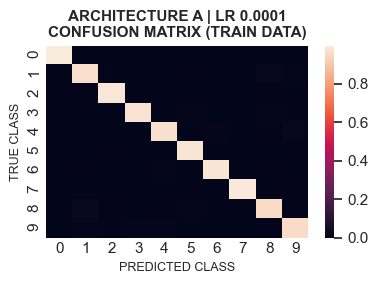

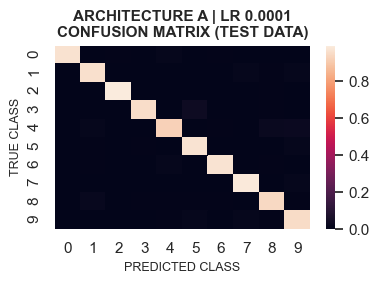

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 1.996 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.04455
 • STOPPING TRAIN ACCURACY : 98.992 %
 • STOPPING VALIDATION ACCURACY : 97.034 %

 >> TRAINING PROGRESS


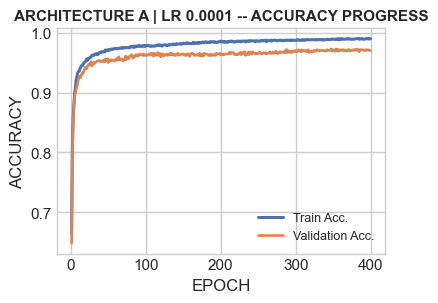

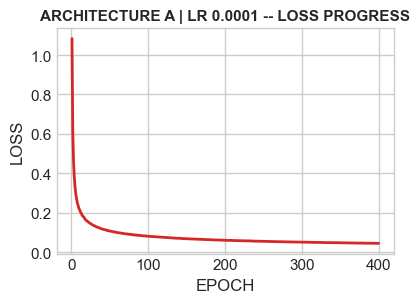


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.600 %
 • TEST ACCURACY : 96.584 %
 • TRAIN LOSS : 0.05321
 • TEST LOSS : 0.11774

 >> MODEL TESTING - CONFUSION MATRICES


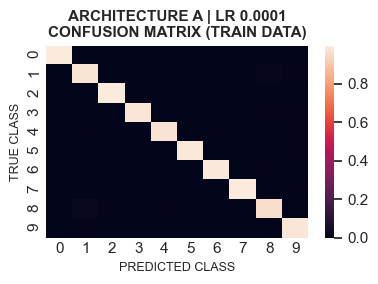

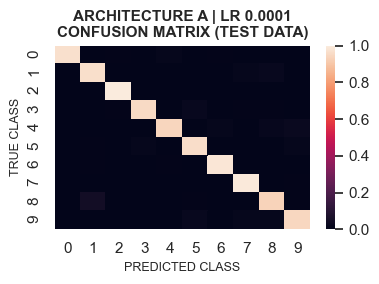

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 5

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.022 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.04368
 • STOPPING TRAIN ACCURACY : 98.992 %
 • STOPPING VALIDATION ACCURACY : 97.034 %

 >> TRAINING PROGRESS


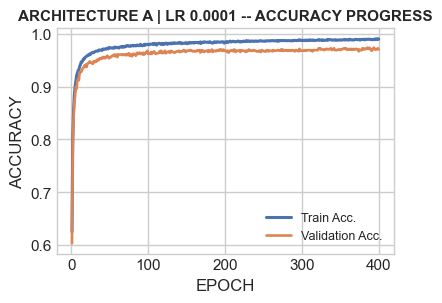

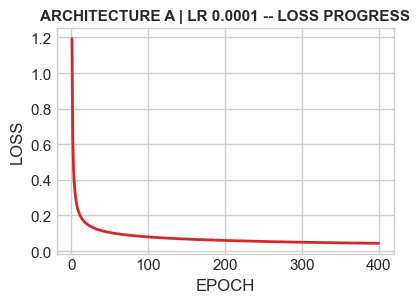


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.600 %
 • TEST ACCURACY : 96.868 %
 • TRAIN LOSS : 0.05345
 • TEST LOSS : 0.11275

 >> MODEL TESTING - CONFUSION MATRICES


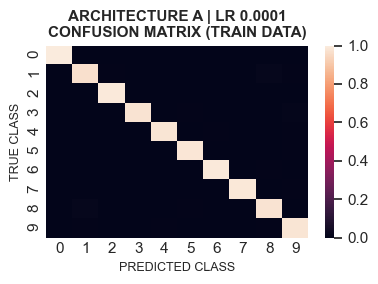

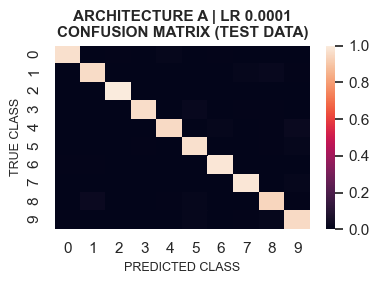

---------------------------------------------------------------------------------------------------- 

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 54
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 6

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.049 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 0.04752
 • STOPPING TRAIN ACCURACY : 98.754 %
 • STOPPING VALIDATION ACCURACY : 97.509 %

 >> TRAINING PROGRESS


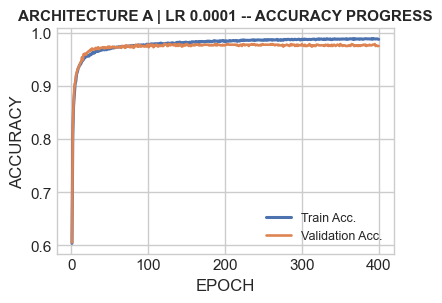

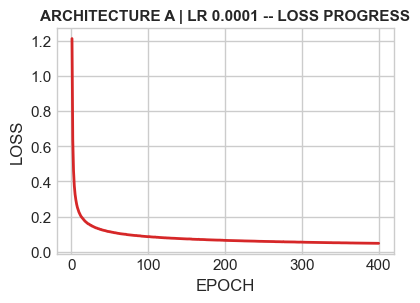


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 98.505 %
 • TEST ACCURACY : 96.940 %
 • TRAIN LOSS : 0.05062
 • TEST LOSS : 0.11652

 >> MODEL TESTING - CONFUSION MATRICES


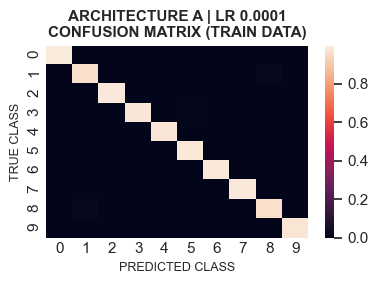

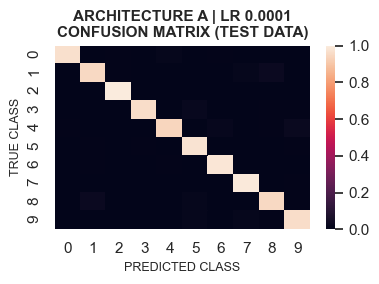

---------------------------------------------------------------------------------------------------- 



In [28]:
early_stopping = [1, 2, 3, 4, 5, 6]
highest_test_acc_obs = 0.0
__best_early_stopping_tol__ = None
for tol in early_stopping :
    print('--' * 50, '\n')
    model = Trainer(__best_architecture_found__, __best_learning_rate_found__, 
                    train_data, early_stopping_tol = tol)
    _, test_acc = model._model_analysis_report(train_data, test_data)
    if test_acc > highest_test_acc_obs :
        highest_test_acc_obs = test_acc
        __best_early_stopping_tol__ = tol
print('--' * 50, '\n')

In [29]:
input_dim = len(train_data[0][0])
model = Handwritten_Digits_Classifier('PART4_Best_Epoch_Num', input_dim, layers[__best_architecture_found__], 10)
train_acc_prog, test_acc_prog = model._strict_train(800, train_data, test_data, 
                                                    verbose = True, verboseGap = 10)

 EPOCH :   1 | TRAIN LOSS : 0.39258 | TRAIN ACC. : 0.93594 | TEST ACC. : 0.93594 
 EPOCH :  11 | TRAIN LOSS : 0.19186 | TRAIN ACC. : 0.97177 | TEST ACC. : 0.94947 
 EPOCH :  21 | TRAIN LOSS : 0.96618 | TRAIN ACC. : 0.91815 | TEST ACC. : 0.91673 
 EPOCH :  31 | TRAIN LOSS : 0.10851 | TRAIN ACC. : 0.98197 | TEST ACC. : 0.95658 
 EPOCH :  41 | TRAIN LOSS : 0.12537 | TRAIN ACC. : 0.97699 | TEST ACC. : 0.95658 
 EPOCH :  51 | TRAIN LOSS : 0.07681 | TRAIN ACC. : 0.98624 | TEST ACC. : 0.97011 
 EPOCH :  61 | TRAIN LOSS : 0.26172 | TRAIN ACC. : 0.96584 | TEST ACC. : 0.95018 
 EPOCH :  71 | TRAIN LOSS : 0.05631 | TRAIN ACC. : 0.98861 | TEST ACC. : 0.96584 
 EPOCH :  81 | TRAIN LOSS : 0.19401 | TRAIN ACC. : 0.96797 | TEST ACC. : 0.95089 
 EPOCH :  91 | TRAIN LOSS : 0.06497 | TRAIN ACC. : 0.98790 | TEST ACC. : 0.95801 
 EPOCH : 101 | TRAIN LOSS : 0.15691 | TRAIN ACC. : 0.97556 | TEST ACC. : 0.96584 
 EPOCH : 111 | TRAIN LOSS : 0.07640 | TRAIN ACC. : 0.98648 | TEST ACC. : 0.96584 
 EPOCH : 121 | T

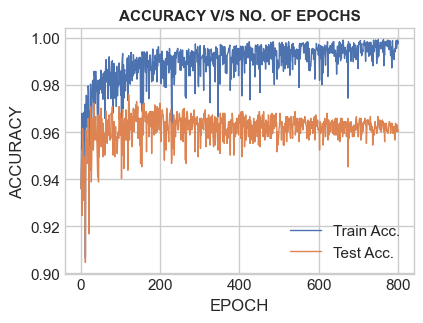

In [31]:
__best_no_of_epochs__ = np.argmax(test_acc_prog) + 1
fontsize = 12
plt.style.use('seaborn-whitegrid')
epochs = len(test_acc_prog)
X = list(range(1, 1 + epochs))
plt.figure(figsize=(4.4, 3.4))
plt.plot(X, train_acc_prog, linewidth = 1)
plt.plot(X, test_acc_prog, linewidth = 1)
plt.xlabel('EPOCH', fontsize = 12)
plt.ylabel('ACCURACY', fontsize = 12)
plt.legend(['Train Acc.', 'Test Acc.'])
plt.title('ACCURACY V/S NO. OF EPOCHS', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

In [32]:
print(' The best architecture is ARCH', __best_architecture_found__, 
      'with hidden layers', layers[__best_architecture_found__])
print(' The best hyperparameters found for this architecture are as follows :-')
print('  • LEARNING RATE :', __best_learning_rate_found__)
print('  • BATCH SIZE :', __best_batch_size__)
print('  • MOMENTUM :', __best_momentum__)
print('  • EARLY STOPPING TOLERANCE :', __best_early_stopping_tol__)
print('  • NO. OF EPOCHS :', __best_no_of_epochs__)

The best architecture is ARCH A with hidden layers []
 The best hyperparameters found for this architecture are as follows :-
  • LEARNING RATE : 0.0001
  • BATCH SIZE : 8
  • MOMENTUM : 0.8
  • EARLY STOPPING TOLERANCE : 6
  • NO. OF EPOCHS : 121


### PART 05
The dimension of the feature vectors is reduced to 2 using Principal Component Analysis. The reduced dimensional data is plotted on a Cartesian plane with all data points of the single class colored the same and data points of different classes differently colored. 

Build the covariance matrix on the 54 attributes of the samples, using only the training samples and from that derive the projection matrix (or weights) to reduce the dimension of the features from 54 to 2. Apply these weights on all the samples in the dataset (both training and testing) and transform them into a new dataset with 2-dimensional feature vectors, and the same class labels. Assign a unique color to each of the 10 classes (without repetition) and plot the data points from each class in the following ways.<br>
– Separate plot for data points of each class.<br>
– Plots for data points of multiple classes partitioned in proper groups.<br>
– Plot for data points from all the classes.

In [33]:
W = PCA_Component_Weights(train_data, verbose = True)
train_data_2D = Two_Dim_Points(train_data, W)
test_data_2D = Two_Dim_Points(test_data, W)
full_data_2D = train_data_2D + test_data_2D

 EIGEN VAL  1 : 175.80023
 EIGEN VAL  2 : 162.30582
 EIGEN VAL  3 : 141.80137
 EIGEN VAL  4 : 101.32664
 EIGEN VAL  5 : 68.52679
 EIGEN VAL  6 : 60.85996
 EIGEN VAL  7 : 54.02768
 EIGEN VAL  8 : 43.64645
 EIGEN VAL  9 : 42.28729
 EIGEN VAL 10 : 37.90186
 EIGEN VAL 11 : 28.60360
 EIGEN VAL 12 : 26.94584
 EIGEN VAL 13 : 22.56745
 EIGEN VAL 14 : 19.97957
 EIGEN VAL 15 : 17.43580
 EIGEN VAL 16 : 16.94269
 EIGEN VAL 17 : 15.23251
 EIGEN VAL 18 : 14.91053
 EIGEN VAL 19 : 11.99506
 EIGEN VAL 20 : 11.66876
 EIGEN VAL 21 : 10.90312
 EIGEN VAL 22 : 9.87161
 EIGEN VAL 23 : 9.13338
 EIGEN VAL 24 : 8.85467
 EIGEN VAL 25 : 8.18030
 EIGEN VAL 26 : 7.46023
 EIGEN VAL 27 : 6.84554
 EIGEN VAL 28 : 6.22525
 EIGEN VAL 29 : 5.64345
 EIGEN VAL 30 : 5.16417
 EIGEN VAL 31 : 4.80173
 EIGEN VAL 32 : 4.36406
 EIGEN VAL 33 : 4.21928
 EIGEN VAL 34 : 4.00337
 EIGEN VAL 35 : 3.91649
 EIGEN VAL 36 : 3.73727
 EIGEN VAL 37 : 3.20314
 EIGEN VAL 38 : 3.04590
 EIGEN VAL 39 : 2.83280
 EIGEN VAL 40 : 2.73657
 EIGEN VAL 41 :

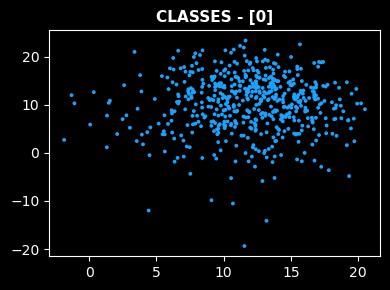

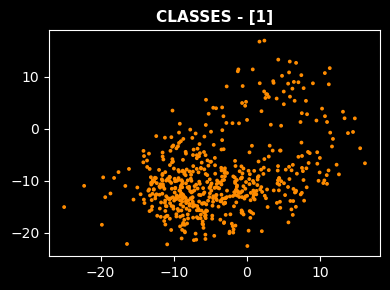

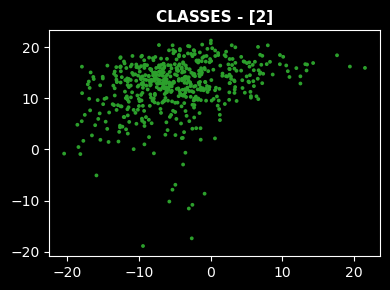

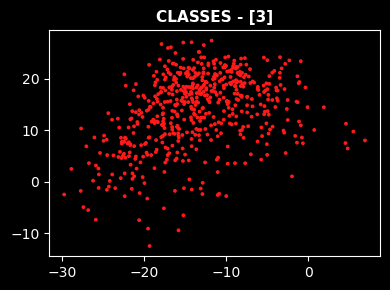

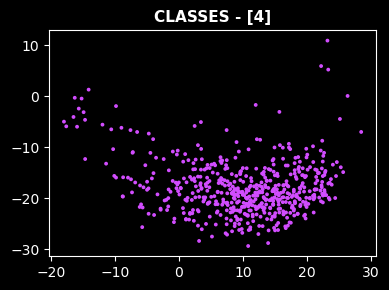

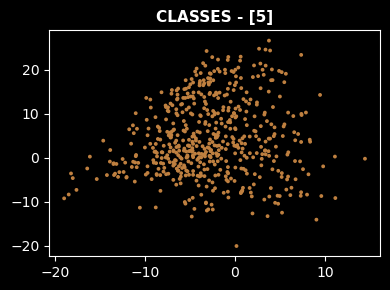

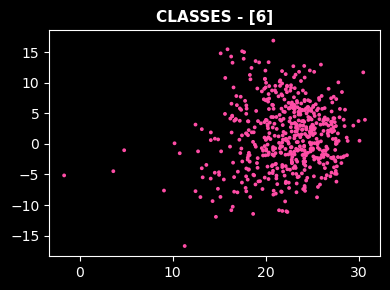

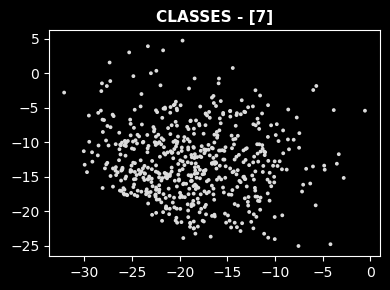

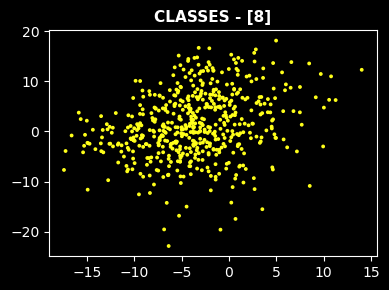

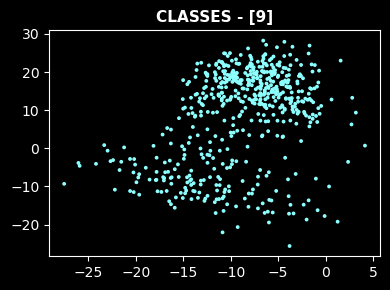

In [34]:
for c in range(10) :
    Plot_2D_Transformed_Data(full_data_2D, [c])

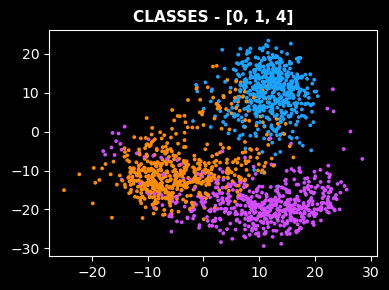

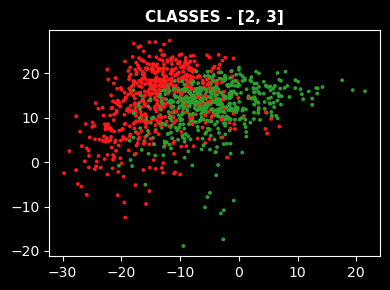

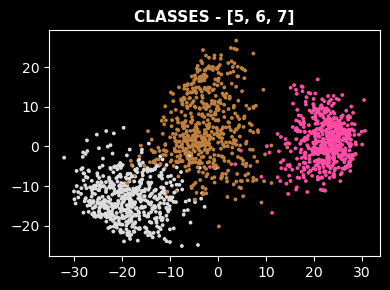

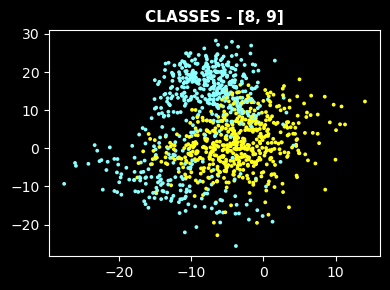

In [35]:
Plot_2D_Transformed_Data(full_data_2D, [0, 1, 4])
Plot_2D_Transformed_Data(full_data_2D, [2, 3])
Plot_2D_Transformed_Data(full_data_2D, [5, 6, 7])
Plot_2D_Transformed_Data(full_data_2D, [8, 9])

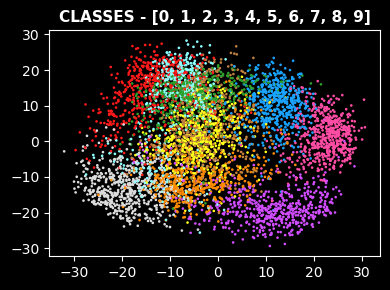

In [36]:
Plot_2D_Transformed_Data(full_data_2D, s = 0.8, alpha = 1)

### PART 06
For each model architecture in the second part, an MLP classifier is trained on the dataset with reduced dimensionality of the features, using the best observed learning rate in the second part as the learning rate for the respective model architecture. The performance of the models obtained on the reduced dataset is compared with the earlier performance.

Train 5 MLP classifiers on the training dataset with reduced dimensions, each with a different model architecture and the best learning rate for that architecture. According to the results of the second part, the 5 models should have the following hyperparameters.

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE A | LR 0.0001
 • INPUT SIZE : 2
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : []
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 97
 • TRAINING TIME : 0.462 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 1.28614
 • STOPPING TRAIN ACCURACY : 52.432 %
 • STOPPING VALIDATION ACCURACY : 48.636 %

 >> TRAINING PROGRESS


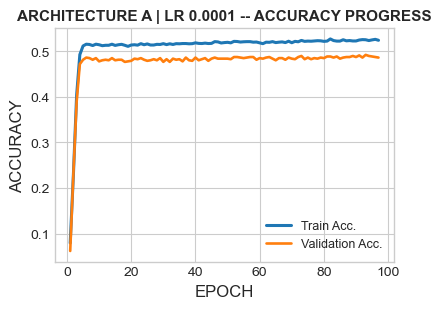

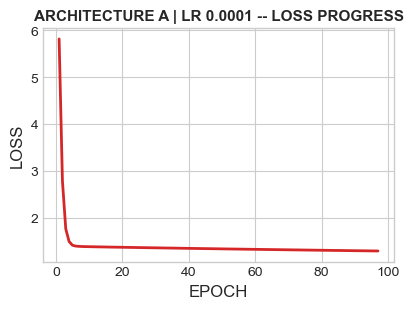


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 51.673 %
 • TEST ACCURACY : 50.819 %
 • TRAIN LOSS : 1.29258
 • TEST LOSS : 1.31385

 >> MODEL TESTING - CONFUSION MATRICES


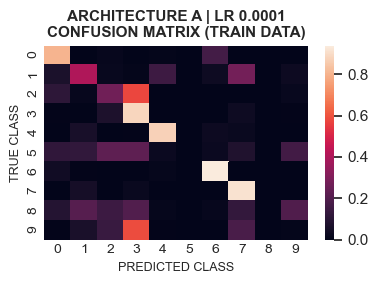

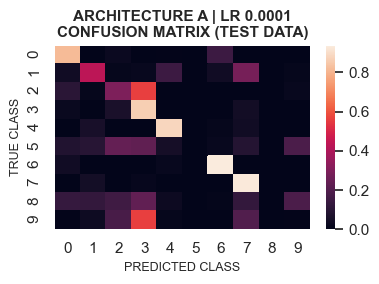

In [38]:
arch_id = 'A'
model = Trainer(arch_id, __best_lr_for_mlp_architectures__[arch_id], train_data_2D)
__ = model._model_analysis_report(train_data_2D, test_data_2D)

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE B | LR 0.0001
 • INPUT SIZE : 2
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2]
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 160
 • TRAINING TIME : 0.989 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 1.32232
 • STOPPING TRAIN ACCURACY : 51.512 %
 • STOPPING VALIDATION ACCURACY : 52.550 %

 >> TRAINING PROGRESS


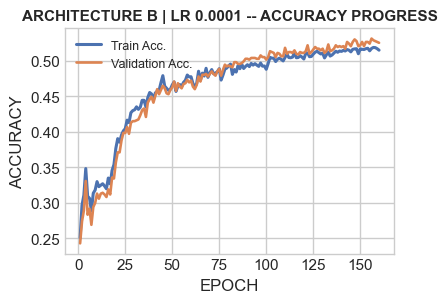

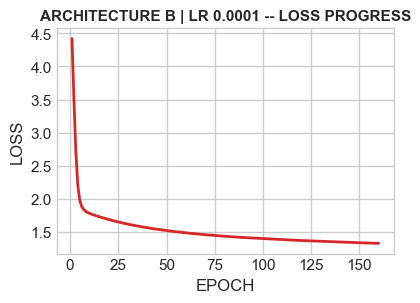


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 51.720 %
 • TEST ACCURACY : 51.174 %
 • TRAIN LOSS : 1.32960
 • TEST LOSS : 1.34624

 >> MODEL TESTING - CONFUSION MATRICES


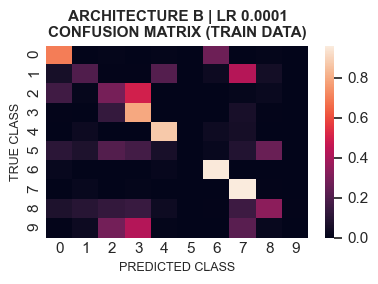

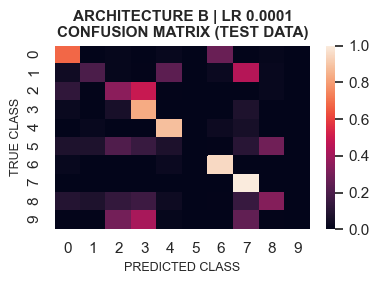

In [39]:
arch_id = 'B'
model = Trainer(arch_id, __best_lr_for_mlp_architectures__[arch_id], train_data_2D)
__ = model._model_analysis_report(train_data_2D, test_data_2D)

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE C | LR 0.0001
 • INPUT SIZE : 2
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [6]
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 2.496 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 1.13989
 • STOPPING TRAIN ACCURACY : 58.096 %
 • STOPPING VALIDATION ACCURACY : 58.126 %

 >> TRAINING PROGRESS


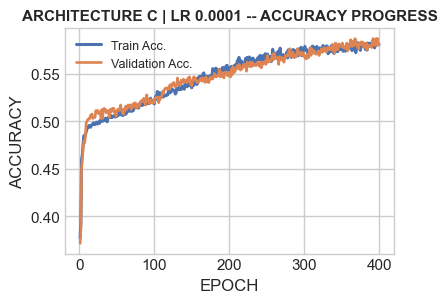

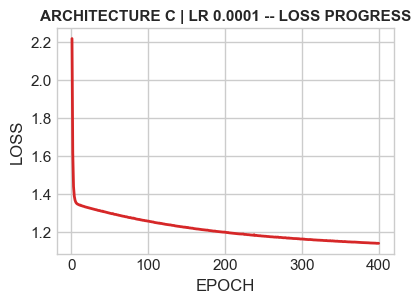


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 58.102 %
 • TEST ACCURACY : 55.730 %
 • TRAIN LOSS : 1.13433
 • TEST LOSS : 1.15921

 >> MODEL TESTING - CONFUSION MATRICES


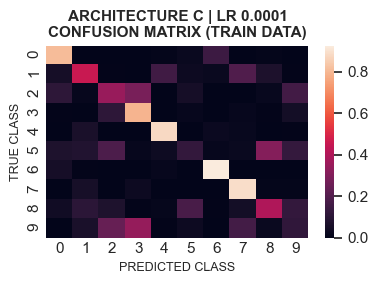

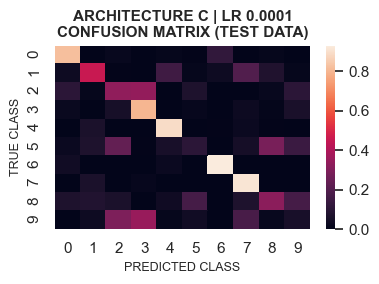

In [40]:
arch_id = 'C'
model = Trainer(arch_id, __best_lr_for_mlp_architectures__[arch_id], train_data_2D)
__ = model._model_analysis_report(train_data_2D, test_data_2D)

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE D | LR 0.01
 • INPUT SIZE : 2
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [2, 3]
 • LEARNING RATE : 0.01
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 125
 • TRAINING TIME : 0.962 mins
 • STOPPING REASON : [Early Stopping] Validation accuracy was not increasing
 • STOPPING TRAIN LOSS : 1.06826
 • STOPPING TRAIN ACCURACY : 58.660 %
 • STOPPING VALIDATION ACCURACY : 63.582 %

 >> TRAINING PROGRESS


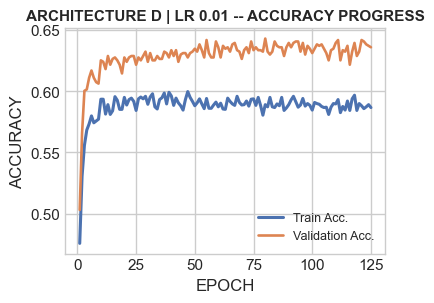

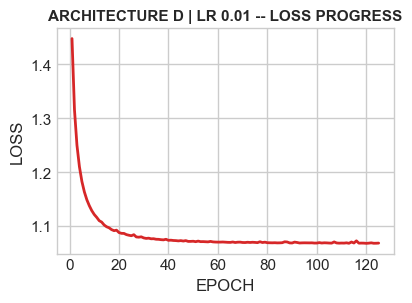


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 59.644 %
 • TEST ACCURACY : 57.224 %
 • TRAIN LOSS : 1.05428
 • TEST LOSS : 1.08120

 >> MODEL TESTING - CONFUSION MATRICES


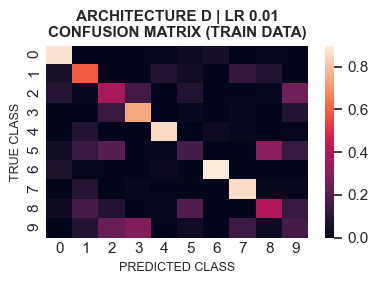

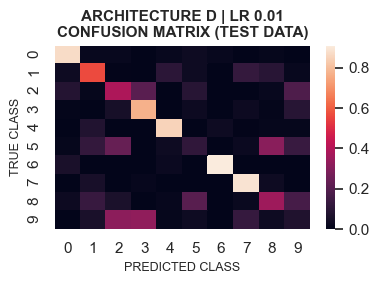

In [41]:
arch_id = 'D'
model = Trainer(arch_id, __best_lr_for_mlp_architectures__[arch_id], train_data_2D)
__ = model._model_analysis_report(train_data_2D, test_data_2D)

   +++ MODEL ANALYSIS REPORT +++

 >> INTRODUCTION
 • NAME : ARCHITECTURE E | LR 0.0001
 • INPUT SIZE : 2
 • OUTPUT SIZE : 10

 >> HYPERPARAMETERS
 • HIDDEN LAYERS SIZES : [3, 2]
 • LEARNING RATE : 0.0001
 • BATCH SIZE : 16
 • MOMENTUM : 0.8
 • EARLY STOPPING TOLERANCE : 4

 >> TRAINING INFORMATION
 • EPOCHS : 400
 • TRAINING TIME : 3.066 mins
 • STOPPING REASON : Maximum number of epochs was reached
 • STOPPING TRAIN LOSS : 1.14320
 • STOPPING TRAIN ACCURACY : 57.117 %
 • STOPPING VALIDATION ACCURACY : 56.465 %

 >> TRAINING PROGRESS


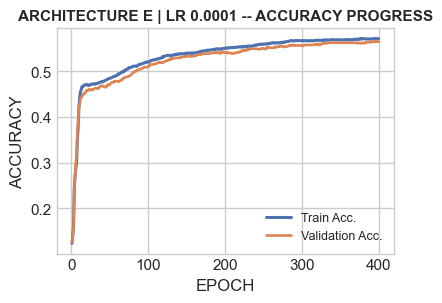

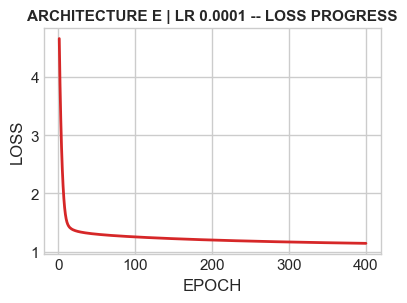


 >> MODEL TESTING - ACCURACY & LOSS
 • TRAIN ACCURACY : 56.987 %
 • TEST ACCURACY : 55.943 %
 • TRAIN LOSS : 1.14874
 • TEST LOSS : 1.17094

 >> MODEL TESTING - CONFUSION MATRICES


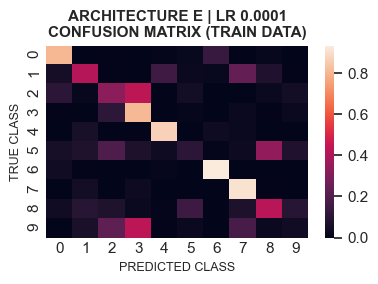

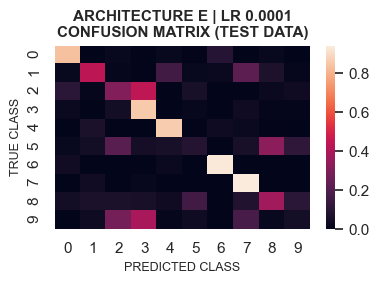

In [42]:
arch_id = 'E'
model = Trainer(arch_id, __best_lr_for_mlp_architectures__[arch_id], train_data_2D)
__ = model._model_analysis_report(train_data_2D, test_data_2D)